# Introduction and Objectives

This project explores the potential of enhancing LLM performance through fine-tuning on brand-specific web data (RefinedWeb) for fashion retail-focused applications, with the ultimate goal of improving brand ranking in LLMs. The exploration also aims to improve the visibility and relevance of AI-driven search and response for businesses that deploy LLMs across websites, support bots, and internal tools. By leveraging fine-tuned models and curated web datasets, the project seeks to deliver actionable insights in areas such as brand perception, brand characteristics, and competitive intelligence.

The overview of the project can be seen in this: [Link](https://docs.google.com/presentation/d/1osce2ePtygd-iho5KEaUy4Jbj97VoPYKr5bpKfSYxWY/edit?usp=sharing)

Note:  
- In the initial phase, the project will proceed with limited memory usage and RAM; therefore, it will start on a small scale.  
- An Apache Spark application is needed to scale up to large-scale processing.  
- Additional space has been provided by the Ai8 Server.

Remarks: This is the first notebook for preprocessing and exploratory analysis. Advanced modeling can be seen in `2_refinedweb-analysis_nlp`.

# Table of Contents

1. [Notebook Setup](#1-Notebook-Setup)
2. [Loading the Data](#2-Loading-the-Data)
3. [Data Exploration](#3-Data-Exploration)
4. [Data Preparation](#4-Data-Preparation)  
   - [4.1 Data Cleaning](#4.1-Data-Cleaning)  
   - [4.2 Handling Null Values](#4.2-Handling-null-values)  
   - [4.3 Feature Engineering](#4.3-Feature-Engineering)  
   - [4.4 VADER for Sentiment Analysis](#4.4-VADER-for-Sentiment-Analysis)  


# 1 Notebook Setup

## Requirement

In [9]:
!pip install -r ../requirements.txt

In [10]:
# IPython / Jupyter Tools ---
from IPython.core.interactiveshell import InteractiveShell

# Core Python
import os
import sys
import gdown
import re
import gc
import psutil
import datetime as dt
import dateutil
from itertools import islice

# Math / Stats / NLP 
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from scipy.stats import pearsonr
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datasets import load_dataset

# Web / Text
from bs4 import BeautifulSoup
import tldextract

# Visualization
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud, STOPWORDS

# PySpark Core
import pyspark
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as f
from pyspark.sql.functions import (
    col, explode, split, lower, regexp_replace, year, to_timestamp,
    count, when, regexp_extract, length, size, instr, concat_ws,
    lpad, to_date, weekofyear, lit, expr, trim, udf, desc,
    min, max, avg
)
from pyspark.sql.types import StringType


<div style="border: 2px solid #3399ff; padding: 10px; border-radius: 6px; background-color: #e6f2ff;">
  <strong>Note:</strong> NLP libraries are added during NLP feature engineering.<br>

### Java Setup (Required for PySpark)

If not already done, please download and extract the JDK:

In [3]:
# !wget https://github.com/adoptium/temurin17-binaries/releases/download/jdk-17.0.10%2B7/OpenJDK17U-jdk_x64_linux_hotspot_17.0.10_7.tar.gz
# !tar -xzf OpenJDK17U-jdk_x64_linux_hotspot_17.0.10_7.tar.gz

This cell sets up Java for PySpark. Make sure jdk-17.0.10+7 is already downloaded and extracted in the current directory.

In [11]:
java_path = os.path.abspath("jdk-17.0.10+7")
os.environ["JAVA_HOME"] = java_path
os.environ["PATH"] = java_path + "/bin:" + os.environ["PATH"]

In [12]:
# Checking
!$JAVA_HOME/bin/java -version

openjdk version "17.0.10" 2024-01-16
OpenJDK Runtime Environment Temurin-17.0.10+7 (build 17.0.10+7)
OpenJDK 64-Bit Server VM Temurin-17.0.10+7 (build 17.0.10+7, mixed mode, sharing)


### Version Check

In [13]:
print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("PySpark:", pyspark.__version__)

Python: 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
NumPy: 1.26.4
Pandas: 2.2.3
PySpark: 4.0.0


In [14]:
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)
print("NLTK:", nltk.__version__)

Matplotlib: 3.10.0
Seaborn: 0.13.2
NLTK: 3.8.1


# 2 Loading the Data

<div style="border: 2px solid #ffcc00; padding: 10px; border-radius: 6px; background-color: #fff9e6;">
  <strong>Remarks:</strong> The initial process loads data using a shell command to extract the path from <code>path.txt</code> using <code>download_parquet</code>, followed by querying the file with DuckDB. You don't need to run this step, but it's included in the folder root structure in case you'd like to see the full process. You can simply <strong>skip process 2 Loading the Data</strong> and move forward to <strong>3 Data Exploration; Loading the Data from Google Drive</strong>  section to perform the next process and download the data.
</div>


<!-- The dataset path is predefined in `path.txt`, located in the `parquet_data` folder. Use the `download_parquet.sh` script to retrieve the data based on the paths listed in this file. After downloading the Parquet files (15 files in this case), use the `filter_primark_duckdb.py` module to filter for records containing the keyword **Primark**, or alternatively, use `filter_brand_duckdb.py` to select multiple retail brands such as **H&M**, **Next** and **Primark**.  
For this project, we will proceed with **Primark** as the target brand for preliminary analysis. -->

<div style="border: 2px solid #3399ff; padding: 10px; border-radius: 6px; background-color: #e6f2ff;">
  <strong>Note:</strong> It is highly recommended to follow the process below <strong>if you are using <code>download_parquet.sh</code> to query file paths</strong>, and then using the corresponding modules in the <code>script</code> folder to filter by brand name. Currently, there are three specific brand filters available: <code>filter_hm_duckdb</code>, <code>filter_primark_duckdb</code>, and <code>filter_zara_duckdb</code>. Following the next steps will help you monitor memory usage and remove temporary files to manage memory more effectively.
</div>


In [5]:
# Set the folder path
folder_path = "parquet_data"

# List all files and their sizes in bytes, excluding paths.txt
file_sizes = []
for filename in os.listdir(folder_path):
    if filename == "paths.txt":
        continue  # Skip paths.txt
    filepath = os.path.join(folder_path, filename)
    if os.path.isfile(filepath):
        size_bytes = os.path.getsize(filepath)
        file_sizes.append({
            "File Name": filename,
            "Size (MB)": round(size_bytes / (1024 * 1024), 2)
        })

# Convert to DataFrame
df_sizes = pd.DataFrame(file_sizes).sort_values(by="Size (MB)", ascending=False)

# Count number of files (excluding paths.txt)
file_count = len(file_sizes)
print(f"Number of files in '{folder_path}': {file_count}")

# Calculate and display total size
total_size_mb = df_sizes["Size (MB)"].sum()
total_size_gb = round(total_size_mb / 1024, 2)
print(f"Total size of files in '{folder_path}': {total_size_gb:.2f} GB")

# Display table
from IPython.display import display
display(df_sizes)

Number of files in 'parquet_data': 56
Total size of files in 'parquet_data': 15.93 GB


File Name  Size (MB)
54  train-00500-of-05534-6fd02adc5942f4fd.parquet     320.18
10  train-00017-of-05534-81d837539550c007.parquet     309.15
21  train-00057-of-05534-3fe06a60d8b3ba1f.parquet     308.34
48  train-00038-of-05534-422efc900cd120fe.parquet     306.44
19  train-00012-of-05534-acf3fb5fee2b7e50.parquet     305.87
42  train-00018-of-05534-6d374c09460d8143.parquet     305.82
53  train-00036-of-05534-75f410e082912165.parquet     300.00
44  train-03500-of-05534-aae8ffe7df807731.parquet     299.86
18  train-00000-of-05534-b8fc5348cbe605a5.parquet     299.27
6   train-00019-of-05534-724cfbde611d86f5.parquet     296.45
51  train-00070-of-05534-330b81f4c3f94ff0.parquet     296.32
8   train-00062-of-05534-84e72000997f426c.parquet     296.27
16  train-00031-of-05534-ee852b432a95e05a.parquet     296.08
32  train-02000-of-05534-f5cb25164097cbf2.parquet     295.74
47  train-03000-of-05534-baea2038194ee545.parquet     295.47
3   train-00025-of-05534-364c4d103a621e0f.parquet     294.91
30  train-00032-of-05534-50284d5c130b0be0.parquet     294.78
7   train-00023-of-05534-68a7ffc65bb0793d.parquet     294.46
22  train-00004-of-05534-cbe1137f523084a7.parquet     293.96
17  train-00037-of-05534-378fea92f8c1f986.parquet     293.84
14  train-01000-of-05534-2f5aada1ebdf607f.parquet     293.29
37  train-02500-of-05534-d493d7bf5f189811.parquet     292.77
29  train-00015-of-05534-0c056156dc81ffc2.parquet     292.14
31  train-00040-of-05534-22ecdb900499b2bf.parquet     291.67
36  train-00005-of-05534-e4a5eae6c1419c9b.parquet     291.31
55  train-00021-of-05534-8ada25673bef5f61.parquet     290.62
43  train-00054-of-05534-2008415143812d16.parquet     290.00
12  train-00016-of-05534-0e0c9b82ed6ccecc.parquet     289.70
20  train-00011-of-05534-7d7970b7bb98922c.parquet     289.69
52  train-04500-of-05534-c9e350218bd3f056.parquet     289.44
0   train-00051-of-05534-b8a6dc2a89918893.parquet     289.33
1   train-00039-of-05534-9b84156534f2e079.parquet     288.62
33  train-00022-of-05534-77181f7417ee27cb.parquet     288.30
24  train-00003-of-05534-b7806bb8ca893c23.parquet     287.95
40  train-01500-of-05534-c8db7eaeff3f8735.parquet     287.85
4   train-00030-of-05534-bfbcdce619c0f298.parquet     287.78
15  train-00027-of-05534-bddc08d9377fbb66.parquet     287.65
25  train-00069-of-05534-5743137cb33052d6.parquet     287.38
45  train-00014-of-05534-2628ae1bc45a28c9.parquet     287.21
41  train-00001-of-05534-9bca3ce859516338.parquet     287.16
23  train-00009-of-05534-f0954d1648b16e88.parquet     286.87
35  train-04000-of-05534-31079247d7deee91.parquet     286.67
9   train-00035-of-05534-4af1fa8b5ec251d2.parquet     286.43
46  train-00061-of-05534-d355002fb13ad062.parquet     286.30
39  train-00006-of-05534-5bc49be138fd315b.parquet     286.08
34  train-00020-of-05534-442ffd4b989fb05d.parquet     285.22
49  train-00024-of-05534-fd6960561baf3ed9.parquet     285.04
28  train-00002-of-05534-01680948bd81de83.parquet     282.74
26  train-00007-of-05534-c185da59aece723d.parquet     281.27
38  train-00013-of-05534-a2a70ea6a8536f67.parquet     280.92
13  train-00010-of-05534-5373970b3705bfc5.parquet     280.66
11  train-00029-of-05534-fd33dccd28c51349.parquet     279.73
50  train-00026-of-05534-031de1cf0c1afcb0.parquet     279.31
27  train-00052-of-05534-d9a6e1c915c881aa.parquet     278.35
5   train-00008-of-05534-8ed029166c6795cf.parquet     277.43
2   train-00028-of-05534-09ffe38fe3bb6c59.parquet     274.67

In [ ]:
# ALL files download
!ls -lh parquet_data/

## Memory Management

To manage memory usage efficiently, this project **deletes all downloaded data files** after running `filtered_primark_duckdb`, which filters only the relevant brand (`Primark`).

This prevents storage overload, especially when working with large `.parquet` datasets. 

The following code removes all `.parquet` files from the folder after filtering is complete, keeping only necessary references like `paths.txt`.

In [17]:
# Get and display the current working directory for file verification
# The environment is based on a Jupyter container with the default 'jovyan' user, as configured by the server.
main_path = os.getcwd()
current_directory = os.path.dirname(main_path) + "/"
current_directory

'/home/jovyan/digitas-analysis-shared/refinedweb-shared/'

### Delete download data

Run this code below **after running Duckdb 
filtered module**. This code have been hidden in initial stage to keep log of dataset comprehensively

<div style="border-left: 4px solid #cc0000; padding: 0.5em 1em; background-color: #ffe6e6; border-radius: 4px; margin-top: 1em;">

<strong>Warning:</strong>  
Running the code block below will permanently <strong>delete the downloaded dataset in parquet_data folder</strong>.  
Ensure **filtered_duckdb module** is completed before proceeding.

</div>

In [7]:
# Folder containing the parquet files
folder_path = current_directory + "data/parquet_data"

# List and delete .parquet files only
for file in os.listdir(folder_path):
    if file.endswith(".parquet"):
        file_path = os.path.join(folder_path, file)
        os.remove(file_path)
        print(f"Deleted: {file}")

Due to limited memory availability, especially when working with large datasets or converting Spark DataFrames to Pandas, it is important to explicitly release memory used by temporary objects. 

This helps avoid memory overflow issues and keeps the notebook session responsive.

Use `del` to delete unnecessary DataFrames and `gc.collect()` to trigger garbage collection and reclaim RAM.

In [11]:
gc.collect()

0

## Check Memory Usage of Parquet File

### Scaling up to mulitple brands (Zara, H&M, Primark)

In [162]:
# Zara
file_path_zara = current_directory + "data/filtered_data/zara.parquet"

In [163]:
# Total size of all files in the Parquet directory
file_size_bytes_zara = os.path.getsize(file_path_zara)
file_size_mb_zara = file_size_bytes_zara / (1024 * 1024)

print(f"Approximate Parquet file size: {file_size_mb_zara:.2f} MB")

Approximate Parquet file size: 48.12 MB


In [164]:
# h&m
file_path_hm = current_directory + "data/filtered_data/hm.parquet"

In [165]:
# Total size of all files in the Parquet directory
file_size_bytes_hm = os.path.getsize(file_path_hm)
file_size_mb_hm = file_size_bytes_hm / (1024 * 1024)

print(f"Approximate Parquet file size: {file_size_mb_hm:.2f} MB")

Approximate Parquet file size: 45.40 MB


In [166]:
# primark
file_path_primark = current_directory + "data/filtered_data/primark.parquet"
# Total size of all files in the Parquet directory
file_size_bytes_primark = os.path.getsize(file_path_primark)
file_size_mb_primark = file_size_bytes_primark / (1024 * 1024)

print(f"Approximate Parquet file size: {file_size_mb_primark:.2f} MB")

Approximate Parquet file size: 7.40 MB


In [167]:
# all brands
file_size_mb_all = file_size_mb_zara + file_size_mb_hm + file_size_mb_primark 
print(f"Approximate Parquet file size (All brands): {file_size_mb_all:.2f} MB")

Approximate Parquet file size (All brands): 100.93 MB


### Join all brands together

In [168]:
# Read each brand file
df_zara = spark.read.parquet(current_directory + "data/filtered_data/zara.parquet")
df_hm = spark.read.parquet(current_directory + "data/filtered_data/hm.parquet")
df_primark = spark.read.parquet(current_directory + "data/filtered_data/primark.parquet")
df_ms = spark.read.parquet(current_directory + "data/filtered_data/ms.parquet")  # Assuming you saved M&S as ms.parquet

In [169]:
# Join (stack) them into a single DataFrame
df_all = df_zara.unionByName(df_hm).unionByName(df_primark).unionByName(df_ms)

In [ ]:
# Save as single files (checkpoint)
df_all.coalesce(1).write.mode("overwrite").parquet(current_directory + "data/filtered_data/all_brands.parquet")

In [170]:
gc.collect()

13008

In [171]:
gc.collect()

0

# 3 Data Exploration

## Data Dictionary

### Falcon RefinedWeb - Original Dataset

| Field Name   | Type              | Description                                                                 |
|--------------|-------------------|-----------------------------------------------------------------------------|
| `content`    | string            | Raw textual content extracted from a web page                              |
| `url`        | string            | The original URL of the crawled web page                                   |
| `timestamp`  | timestamp (string)| The date and time when the page was crawled by CommonCrawl (not publish time) |
| `dump`       | string            | Identifier for the specific CommonCrawl snapshot (e.g., `CC-MAIN-2013-20`)  |
| `segment`    | string            | Internal segment identifier within the crawl dump                          |
| `image_urls` | list of strings   | List of image URLs found on the web page (may be empty if no images exist) |


Datasource: [Link](https://huggingface.co/datasets/tiiuae/falcon-refinedweb)

## Spark Application for Preprocessing

The Spark job architecture used in this project is built on a reusable framework defined in `sparkcc.py`, which provides a flexible base class (`CCSparkJob`) for processing Common Crawl data using PySpark. This modular design separates concerns such as argument parsing, I/O handling, and distributed processing logic, making it easy to extend and customize for different analysis tasks.

The specific job used for this project is `word_count_parquet.py`, which extends `CCSparkJob` to perform word frequency analysis on a local Parquet dataset (e.g., `primark.parquet`). This job reads the `content` column from the dataset, tokenizes text into lowercase words, and computes two metrics:
- **Term Frequency (TF):** The total number of times each word appears across the entire dataset.
- **Document Frequency (DF):** The number of unique documents each word appears in.
`
Text tokenization is handled using PySpark functions such as `explode`, `split`, and `lower`, and results are aggregated using `groupBy` and `count`. The job constructs a final output in the form of an RDD of key-value pairs, where the key is the word and the value is a dictionary containing both TF and DF counts.

The results are written to the default Spark SQL warehouse as a managed table or to a specified output directory in Parquet format. The job uses the output compression and formatting options specified via command-line arguments.

This implementation is adapted from the original [Common Crawl Spark word count job](https://github.com/commoncrawl/cc-pyspark/blob/main/word_count.py), replacing the raw WARC processing with a direct Parquet input workflow. This adaptation simplifies processing for brand-filtered datasets and improves performance by avoiding external file streaming.

To execute the job, run `word_count_parquet.py` with the appropriate `--input` and `--output` arguments. The output will be written to the `spark-warehouse` folder or the specified destination in Parquet format.

**Note on `word_count` Usage**

The `word_count` functionality was initially used during the exploratory stage of the analysis. However, for clarity and to maintain a clean final version of the notebook, this code has been removed.

If future research or development requires this functionality again, it can be found modularized in the `word_count_parquet` module located in the `scripts/` folder.

In [15]:
# Get and display the current working directory for file verification
# The environment is based on a Jupyter container with the default 'jovyan' user, as configured by the server.
main_path = os.getcwd()
current_directory = os.path.dirname(main_path) + "/"
current_directory

'/home/jovyan/digitas-analysis-shared/refinedweb-shared/'

In [16]:
# Initialize Spark with memory config, Allocate up to 16 GB of RAM for the Spark driver process
spark = SparkSession.builder \
    .appName("RefinedWebAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

# Set log level to show only ERROR and above (suppress INFO/WARN)
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/05 17:57:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/05 17:57:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Loading the Data from Google Drive

In [18]:
# Google drive path
os.makedirs("../data/filtered_data", exist_ok=True)

In [19]:
# path to download
file_id = "1SDUwnTlS2ctEbZq_2gvRVXpc3gw87avE"
output_path = "../data/filtered_data/all_brands.parquet" 

In [20]:
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1SDUwnTlS2ctEbZq_2gvRVXpc3gw87avE
From (redirected): https://drive.google.com/uc?id=1SDUwnTlS2ctEbZq_2gvRVXpc3gw87avE&confirm=t&uuid=73916567-3d71-4836-91ce-574b210b0b59
To: /home/jovyan/digitas-analysis-shared/refinedweb-shared/data/filtered_data/all_brands.parquet
100%|██████████| 110M/110M [00:00<00:00, 159MB/s] 


'../data/filtered_data/all_brands.parquet'

In [21]:
df = spark.read.parquet(current_directory + "data/filtered_data/all_brands.parquet")

### Basic Metadata

In [24]:
# Register as temporary view for SQL queries
df.createOrReplaceTempView("all_brands")

In [25]:
# Count all rows
spark.sql("SELECT COUNT(*) FROM all_brands").show()

+--------+
|count(1)|
+--------+
|   20017|
+--------+



In [26]:
# Check Schema
df.printSchema()

root
 |-- content: string (nullable = true)
 |-- url: string (nullable = true)
 |-- timestamp: timestamp_ntz (nullable = true)
 |-- dump: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- image_urls: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)



In [27]:
# Preview top 10 rows as DataFrame
preview_df = spark.sql("SELECT * FROM all_brands LIMIT 10")
preview_df.show(5)  # disable truncation of long strings

+--------------------+--------------------+-------------------+---------------+-------------+--------------------+
|             content|                 url|          timestamp|           dump|      segment|          image_urls|
+--------------------+--------------------+-------------------+---------------+-------------+--------------------+
|Skirt: Bar III Bl...|http://fashboulev...|2013-05-18 10:41:21|CC-MAIN-2013-20|1368696382261|                  []|
|from Milk Teeths ...|http://rubyslippe...|2013-05-18 11:02:46|CC-MAIN-2013-20|1368696382261|[[http://i904.pho...|
|From a reader:\nI...|http://wdtprs.com...|2013-05-18 10:53:59|CC-MAIN-2013-20|1368696382261|[[http://wdtprs.c...|
|So here’s how the...|http://theviewspa...|2013-05-18 10:40:59|CC-MAIN-2013-20|1368696382261|                  []|
|Hijabs and Hats\n...|http://www.artiza...|2013-05-18 10:34:41|CC-MAIN-2013-20|1368696382261|                  []|
+--------------------+--------------------+-------------------+---------------+-

## Spark SQL & pandas Dataframe

To inspect full text fields (such as long sentences) more easily, it's often helpful to convert Spark SQL results into a pandas DataFrame. This enables better formatting and interaction in notebooks.

### Understanding df.toPandas() Memory Issue

Using `df.toPandas()` loads the entire DataFrame into the Driver's RAM, which can cause memory errors if the dataset is too large. This often results in connection failures, but limiting the data size (e.g., `df.limit(1000).toPandas()`) works because it stays within memory limits. The issue is due to insufficient RAM for the full dataset.

In [28]:
# Show full column width for all text columns
pd.set_option('display.max_colwidth', None)

In [29]:
# Convert Spark DataFrame to Pandas (just 1000 rows)
pdf = df.limit(1000).toPandas()

# Preview
pdf.head(3)

content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [30]:
pd.reset_option('display.max_colwidth')

### Memory Management

In [31]:
# Once done, explicitly delete the Pandas DataFrame to free memory
del pdf  # Removes the variable reference

# Force garbage collection to reclaim memory from RAM
gc.collect()  # Ensures Python releases unused memory immediately

63

In [32]:
gc.collect()

0

### Time-Based Analysis

In [33]:
spark.sql("""
    SELECT 
        MIN(timestamp) AS earliest_date,
        MAX(timestamp) AS latest_date
    FROM all_brands
""").show()

+-------------------+-------------------+
|      earliest_date|        latest_date|
+-------------------+-------------------+
|2008-05-13 11:17:30|2022-09-25 09:19:02|
+-------------------+-------------------+



In [34]:
# Number of records per year (using SQL)
# First, ensure the timestamp column is cast properly
df_with_year = spark.sql("""
    SELECT *, YEAR(TO_TIMESTAMP(timestamp)) AS year 
    FROM all_brands
""")
df_with_year.createOrReplaceTempView("primark_with_year")

spark.sql("""
    SELECT 
        year, 
        COUNT(*) AS records 
    FROM primark_with_year 
    GROUP BY year 
    ORDER BY year
""").show()

+----+-------+
|year|records|
+----+-------+
|2008|     32|
|2009|    320|
|2012|    171|
|2013|    231|
|2014|   1031|
|2015|    637|
|2016|    363|
|2017|   3666|
|2018|   2878|
|2019|   3094|
|2020|   2367|
|2021|   3422|
|2022|   1805|
+----+-------+



The records from 2008 to 2013 were filtered out because they account for a relatively small portion of the dataset and may not reflect the more current patterns of web content. These early years have significantly fewer entries compared to later periods, which could introduce temporal bias or inconsistencies in model training. By focusing on data from 2014 onward, we ensure a more robust, relevant, and balanced dataset that better represents modern web usage and language.

In [35]:
# Add 'year' column and filter rows in one chain
df_filtered = df.withColumn("year", year(to_timestamp("timestamp"))) \
                .filter((col("year") >= 2014) & (col("year") <= 2022))

In [36]:
# After removals, Group by year and count records
df_filtered.groupBy("year").count().orderBy("year").show()

+----+-----+
|year|count|
+----+-----+
|2014| 1031|
|2015|  637|
|2016|  363|
|2017| 3666|
|2018| 2878|
|2019| 3094|
|2020| 2367|
|2021| 3422|
|2022| 1805|
+----+-----+



### Saved as new parquet files (Checkpoint)

**Note:** After downloading the dataset once, the code block below should be intentionally hidden to prevent unintentional multiple downloads. This is considered a best practice to avoid redundant operations that may consume unnecessary resources or result in duplicate file writes.

In [37]:
# Save filtered data as a single files
filtered_path = os.path.join(current_directory, "data/filtered_data/all_brands_2014_2022.parquet")
df_filtered.coalesce(1).write.mode("overwrite").option("compression", "snappy").parquet(filtered_path)

In [38]:
# Delete old dataframe
# del df
gc.collect()

187

In [39]:
gc.collect()

0

### Create new temporary view

In [40]:
# Read the single Parquet file
df_filtered  = spark.read.parquet(current_directory + "data/filtered_data/all_brands_2014_2022.parquet")

# Show basic info
df_filtered.show(5)
df_filtered.printSchema()

+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+
|             content|                 url|          timestamp|           dump|        segment|          image_urls|year|
+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+
|Look: Palm Leaves...|https://trendtati...|2019-12-05 16:53:45|CC-MAIN-2019-51|1575540481281.1|[[https://cdn-sta...|2019|
|Mexico's Slim top...|https://www.nbr.c...|2019-12-05 18:07:11|CC-MAIN-2019-51|1575540481281.1|[[https://d3tq6tj...|2019|
|Girl goes viral o...|https://www.zmonl...|2019-12-05 17:36:17|CC-MAIN-2019-51|1575540481281.1|[[https://www.zmo...|2019|
|Fashion Women's A...|http://arubabeach...|2019-12-05 16:46:15|CC-MAIN-2019-51|1575540481281.1|[[https://i.ebayi...|2019|
|Speaking Engageme...|http://www.zaraph...|2019-12-05 16:48:23|CC-MAIN-2019-51|1575540481281.1|                  []|2019|
+--------------------+--

In [41]:
df_filtered.createOrReplaceTempView("all_brands_filtered")

### Check File Size of filtered Parquet File

In [42]:
# Set folder path
parquet_folder_path = os.path.join(current_directory, "data/filtered_data/all_brands_2014_2022.parquet")

# Sum file sizes in folder
file_size_bytes = sum(
    os.path.getsize(os.path.join(parquet_folder_path, f))
    for f in os.listdir(parquet_folder_path)
    if os.path.isfile(os.path.join(parquet_folder_path, f))
)

# Convert to MB
file_size_mb = file_size_bytes / (1024 ** 2)

# Print result
print(f"File size: {file_size_mb:.2f} MB")

File size: 99.77 MB


### Null / Missing Value Counts

While the Refinedweb dataset is designed to minimize missing values it's important note that given its web-based origins some instances might still contain incomplete or less informative content. It is a good practice check null  during exploring the data.

In [43]:
spark.sql("""
    SELECT
        SUM(
            CASE 
                WHEN content IS NULL OR TRIM(content) = '' OR LENGTH(TRIM(content)) < 10
                THEN 1 ELSE 0 
            END
        ) AS missing_content,
        
        SUM(CASE WHEN url IS NULL THEN 1 ELSE 0 END) AS null_url,
        SUM(CASE WHEN timestamp IS NULL THEN 1 ELSE 0 END) AS null_timestamp,
        SUM(CASE WHEN dump IS NULL THEN 1 ELSE 0 END) AS null_dump,
        SUM(CASE WHEN segment IS NULL THEN 1 ELSE 0 END) AS null_segment,
        SUM(CASE WHEN image_urls IS NULL THEN 1 ELSE 0 END) AS null_image_urls,
        SUM(CASE WHEN image_urls IS NULL OR size(image_urls) = 0 THEN 1 ELSE 0 END) AS missing_image_urls
    FROM all_brands_filtered
""").show()

[Stage 27:====================================================>   (15 + 1) / 16]

+---------------+--------+--------------+---------+------------+---------------+------------------+
|missing_content|null_url|null_timestamp|null_dump|null_segment|null_image_urls|missing_image_urls|
+---------------+--------+--------------+---------+------------+---------------+------------------+
|              0|       0|             0|        0|           0|              0|             12304|
+---------------+--------+--------------+---------+------------+---------------+------------------+



The query counts `NULL` values across key columns in the `all_brands_filtered` dataset. For most columns, a standard `IS NULL` check is used. However, for the `image_urls` field, there is a distinction:

- `null_image_urls`: Counts rows where `image_urls` is explicitly `NULL`.
- `missing_image_urls`: Counts rows where `image_urls` is either `NULL` **or** an empty list `[]`, indicating no associated image links.

This distinction is important because in many rows, `image_urls` may exist as an empty array (not `NULL`), meaning the field is present but contains no data. Only rows with actual image URLs (non-empty lists) are excluded from the `missing_image_urls` count. This image_urls null values will be kept and remains the same cause it is not the real null values.

#### Missing Content Values 

Even when results show zero null values (`IS NULL = 0`), this does not guarantee that the data is complete or meaningful especially in real-world NLP tasks involving web content. Fields like `content` may technically exist but still be empty, contain only whitespace, or hold minimal non-informative text. This is common in web analytics and crawling scenarios. Possible reasons can be referred to as cases where the content visually appears but actually empty: 

| **Reason**             | **Explanation**                                                                 | **Sample Value**                     | **Real Cause**                                                                 |
|------------------------|----------------------------------------------------------------------------------|--------------------------------------|----------------------------------------------------------------------------------|
| Whitespace only        | Content contains only spaces, tabs, or newlines                                 | `"   "`, `"\n\t"`                    | HTML stripped, page had no real text                                            |
| Empty string           | Field exists but is an empty string                                             | `""`                                 | Parsing artifact or empty text block                                            |
| Very short boilerplate | Contains <10 characters, often footers or filler text                           | `"Home"`, `"Read more"`              | Non-informative UI or navigation content                                        |
| Soft 404               | Page returned HTTP 200 but contains error message                               | `"Not Found"` or `"Oops"`            | Fake or misconfigured web page                                                  |
| JavaScript-only page   | Crawler cannot render JS, so no visible text is captured                        | `""`                                 | Content is dynamically rendered (JS), not visible to crawler                    |
| Redirect or interstitial | Pages with messages like “redirecting…” or ads with no body content            | `"Click here to continue"`           | Interstitial page detected and crawled                                          |
| Minified tag fragments | Stripped tags leave behind tokens or invisible leftovers                        | `"<div></div>"`, `"<script>"`        | Incomplete tag removal or malformed HTML                                        |
| Meta-content only      | Page includes only meta tags, SEO text, or copyright                            | `"© 2024 Company"`                   | Legal or meta-only content with no body                                         |
| CAPTCHA/bot trap       | Pages designed to block crawlers show blank/blocked content                     | `""` or `"verify you are human"`     | Anti-bot protection prevents proper crawling                                    |


Additionally **PySpark is more effective than Spark SQL in detecting missing or low-value content** because it handles data types more robustly, especially when fields like `content` are not strictly strings. While Spark SQL may silently skip over non-string values or whitespace anomalies, PySpark allows precise chaining of conditions like `.isNull()`, `trim()`, and `length()`making it better suited for identifying visually empty content that is not technically null. This makes PySpark the preferred choice for real-world NLP and web data analysis.

The code below helps detect such "functionally empty" content by checking not just for `NULL`, but also for blank strings and very short content, offering a more accurate view of missing or low-quality data.

In [48]:
missing_content = df_filtered.filter(
    col("content").isNull() |
    (trim(col("content")) == "") |
    (length(trim(col("content"))) < 10)
).select("content", "URL", "timestamp")

In [49]:
missing_content_count = missing_content.count()

In [50]:
# Count rows where content is null, empty, or very short
missing_content.show(truncate=False)
print("Missing or low-value content rows:", missing_content_count)

[Stage 41:==================================================>     (10 + 1) / 11]

+-------+---+---------+
|content|URL|timestamp|
+-------+---+---------+
+-------+---+---------+

Missing or low-value content rows: 0


There is no null values in content records

### Distinct Counts & Duplicate Detection

In [51]:
spark.sql("""
    SELECT
        COUNT(*) AS total_rows,
        COUNT(DISTINCT url) AS distinct_urls,
        COUNT(DISTINCT dump) AS distinct_dumps,
        COUNT(DISTINCT segment) AS distinct_segments
    FROM all_brands_filtered
""").show()

+----------+-------------+--------------+-----------------+
|total_rows|distinct_urls|distinct_dumps|distinct_segments|
+----------+-------------+--------------+-----------------+
|     19263|        18218|            76|              176|
+----------+-------------+--------------+-----------------+



### URLs Frequent Value

In [52]:
spark.sql("""
    SELECT
        url,
        COUNT(*) AS occurrences
    FROM all_brands_filtered
    GROUP BY url
    ORDER BY occurrences DESC
    LIMIT 10
""").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+-----------+
|url                                                                                                                        |occurrences|
+---------------------------------------------------------------------------------------------------------------------------+-----------+
|http://www.mumsnet.com/Talk/style_and_beauty/1949659-Quality-not-quantity-clothes                                          |4          |
|http://www.belfasttelegraph.co.uk/life/fashion-beauty/fashion-spy-kim-kardashians-style-is-fresh-and-uptodate-34442230.html|4          |
|http://www.littleelliemae.co.uk/2016/02/my-outfit-of-days-littleelliemae.html                                              |4          |
|https://www.dorset.live/news/dorset-news/asda-tesco-closed-queen-funeral-7584429                                           |3          |
|http://www.morningink.com/tag/win

The URL frequency analysis shows that most URLs in the dataset are unique, with the highest occurrence being just 4. This suggests that the content comes from a wide variety of web pages rather than being concentrated on a few sources. Such diversity is common in web-scraped corpora and indicates that the dataset captures a broad range of topics and domains, **which is beneficial for general-purpose language modeling.** However, it also implies that URL-based deduplication or clustering would offer limited value which they may **limit deduplication or source-based grouping strategies.**

### Text Field Length Stats (character length)

In [53]:
spark.sql("""
    SELECT
        MIN(LENGTH(content)) AS min_char_length,
        MAX(LENGTH(content)) AS max_char_length,
        ROUND(AVG(LENGTH(content)), 2) AS avg_char_length
    FROM all_brands_filtered
""").show()

[Stage 51:====================================================>   (15 + 1) / 16]

+---------------+---------------+---------------+
|min_char_length|max_char_length|avg_char_length|
+---------------+---------------+---------------+
|             20|         590623|         8465.7|
+---------------+---------------+---------------+



The dataset shows varied text lengths: the shortest entry has 20 characters, while the longest reaches 590,623. On average, each record contains 8466 characters. **This suggests the dataset includes both concise and lengthy web content**. For efficient processing, consider trimming outliers or segmenting long entries, especially when applying NLP models.

### Empty image_urls lists

In [54]:
spark.sql("""
    SELECT
        COUNT(*) AS total_records,
        SUM(CASE WHEN SIZE(image_urls) = 0 THEN 1 ELSE 0 END) AS empty_image_lists
    FROM all_brands_filtered
""").show()

+-------------+-----------------+
|total_records|empty_image_lists|
+-------------+-----------------+
|        19263|            12304|
+-------------+-----------------+



In [55]:
# Preview rows with empty image_urls list
spark.sql("""
    SELECT *
    FROM all_brands_filtered
    WHERE SIZE(image_urls) = 0
    LIMIT 10
""").show()

+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
|             content|                 url|          timestamp|           dump|        segment|image_urls|year|
+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
|Speaking Engageme...|http://www.zaraph...|2019-12-05 16:48:23|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|In 1995 fresh out...|https://teamlazza...|2019-12-05 17:00:27|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|HUGE apologies fo...|http://www.little...|2019-12-05 16:48:49|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|.\nOnly in her te...|https://www.latim...|2019-12-05 17:51:27|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|MEMBER'S LOGIN\nY...|https://www.snap-...|2019-12-05 17:29:11|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|By John D. Sutter...|http://thecnnfree...|2019-12-05 17:21:01|CC-MAIN-2019-51|1575540481281.1|        [

RefinedWeb is a multimodal dataset; however, out of 19263 total records in the dataset, 12304 (approximately 64%) contain empty `image_urls` lists, indicating the absence of associated image data. This suggests that a significant portion of the dataset is text-only, which may limit its suitability for tasks requiring image-text alignment.

In [56]:
# Remove unnecessary dataframes for memory optimisation
gc.collect()

752

# 4 Data Preparation

### Preprocessing Guidelines for Fine-Tuning LLMs on RefinedWeb Data

RefinedWeb, having undergone Macro Data Refinement (MDR), provides a high-quality, large-scale web dataset suitable for training and fine-tuning transformer-based models such as GPT, BERT, and RoBERTa. Since these models rely on rich linguistic structure—including punctuation, casing, and diverse expressions—**only minimal and structure-focused preprocessing** is appropriate.

Over-cleaning risks removing valuable cues that models use to learn context and nuance. Preprocessing in this project therefore focuses on **cleaning artifacts** while preserving the original linguistic variety.

#### What RefinedWeb Already Provides

- Removal of boilerplate, navigation, and script content  
- Deduplication across domains and pages  
- Document length normalization for efficient batching  
- English-only filtering for language consistency  
- Clean structure compatible with standard LLM tokenizers

#### Additional Preprocessing (Light Structural Cleaning)

| Step                     | Description                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| HTML Tag Removal         | Remove any residual HTML or markup tags for clean, readable text.           |
| Mention Replacement      | Replace usernames like `@username` with `[USER]` to anonymize and standardize. |
| Hashtag Removal          | Remove `#hashtag` tokens to reduce clutter unless task-relevant.            |
| Placeholder Cleanup      | Remove artifacts such as `[FIGURE]`, `[CAPTION]`, or `[VIDEO]` tags.        |
| Unicode Cleanup          | Remove invisible or special characters (e.g., `\xa0`, `\u200b`).            |
| Whitespace Normalization | Collapse excessive spacing and trim surrounding whitespace.                 |
| Spam and Noise Filtering | Remove spammy or templated lines (e.g., “follow me”, blog links).           |

#### Preprocessing Steps to Avoid

| Step                   | Reason                                                                        |
|------------------------|--------------------------------------------------------------------------------|
| Stopword Removal       | Stopwords convey sentence flow and grammatical structure.                     |
| Lowercasing            | Casing conveys named entities, emphasis, and sentence boundaries.             |
| Lemmatization/Stemming | Not needed; LLMs benefit from learning surface forms in context.              |
| Spelling Correction    | Lexical variation reflects natural usage, including informal and creative forms. |
| Manual Tokenization    | Tokenization should be handled by the model's built-in tokenizer.             |


### Summary

### Preprocessing Guidelines for Fine-Tuning LLMs on RefinedWeb Data

RefinedWeb, having undergone Macro Data Refinement (MDR), provides a high-quality, large-scale web dataset suitable for training and fine-tuning transformer-based models such as GPT, BERT, and RoBERTa. Since these models rely on rich linguistic structure—including punctuation, casing, and diverse expressions—**only minimal and structure-focused preprocessing** is appropriate.

Over-cleaning risks removing valuable cues that models use to learn context and nuance. Preprocessing in this project therefore focuses on **cleaning artifacts** while preserving the original linguistic variety.

## 4.1 Data Cleaning

<div style="border: 2px solid #3399ff; padding: 10px; border-radius: 6px; background-color: #e6f2ff;">
  <strong>Note:</strong> Further normalization (e.g., lemmatization, lowercasing, stopword removal) and aggressive text cleaning are <strong>deferred intentionally</strong> to retain rich linguistic features for analysis in early stages. The deeper normalization will be conducted during <strong>feature engineering phase<strong>, based on task-specific requirements.<br>

In [57]:
# Preview 
df_filtered.show()

+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+
|             content|                 url|          timestamp|           dump|        segment|          image_urls|year|
+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+
|Look: Palm Leaves...|https://trendtati...|2019-12-05 16:53:45|CC-MAIN-2019-51|1575540481281.1|[[https://cdn-sta...|2019|
|Mexico's Slim top...|https://www.nbr.c...|2019-12-05 18:07:11|CC-MAIN-2019-51|1575540481281.1|[[https://d3tq6tj...|2019|
|Girl goes viral o...|https://www.zmonl...|2019-12-05 17:36:17|CC-MAIN-2019-51|1575540481281.1|[[https://www.zmo...|2019|
|Fashion Women's A...|http://arubabeach...|2019-12-05 16:46:15|CC-MAIN-2019-51|1575540481281.1|[[https://i.ebayi...|2019|
|Speaking Engageme...|http://www.zaraph...|2019-12-05 16:48:23|CC-MAIN-2019-51|1575540481281.1|                  []|2019|
|In 1995 fresh out...|ht

In [58]:
# Preview the content column
df_filtered.select("content").show()

+--------------------+
|             content|
+--------------------+
|Look: Palm Leaves...|
|Mexico's Slim top...|
|Girl goes viral o...|
|Fashion Women's A...|
|Speaking Engageme...|
|In 1995 fresh out...|
|HUGE apologies fo...|
|The future value ...|
|.\nOnly in her te...|
|MEMBER'S LOGIN\nY...|
|In a ‘thriller’ g...|
|By John D. Sutter...|
|Listen cultures f...|
|As we appear to b...|
|It's going to be ...|
|RADIO-LISTS: BBC ...|
|Is there any hope...|
|Think about this ...|
|When go. As much ...|
|Istanbul can be q...|
+--------------------+
only showing top 20 rows


In [59]:
# Convert Spark DataFrame to Pandas (full conversion)
pdf_filtered = df_filtered.toPandas()
pdf_filtered.head(10)

content  \
0  Look: Palm Leaves - Great for casual - 11 Augu...   
1  Mexico's Slim top Gates in billionaires index\...   
2  Girl goes viral on Instagram for posting outfi...   
3  Fashion Women's Ankle Boots Chunky Heels Round...   
4  Speaking Engagements\nFor Professional Booking...   
5  In 1995 fresh out of college I walked into our...   
6  HUGE apologies for my blog being basically non...   
7  The future value factor is also called future ...   
8  .\nOnly in her teens did Natalie begin to rebe...   
9  MEMBER'S LOGIN\nYou are here: Home | Blog | Tr...   

                                                 url           timestamp  \
0  https://trendtation.com/wall?showallcountries=... 2019-12-05 16:53:45   
1  https://www.nbr.co.nz/article/mexicos-slim-top... 2019-12-05 18:07:11   
2  https://www.zmonline.com/the-latest/girl-goes-... 2019-12-05 17:36:17   
3          http://arubabeach-resort.com/fg9989/inny/ 2019-12-05 16:46:15   
4  http://www.zaraphillips.net/contact-zara-phill... 2019-12-05 16:48:23   
5                   https://teamlazzara.com/2019/03/ 2019-12-05 17:00:27   
6  http://www.littleelliemae.co.uk/2016/02/my-out... 2019-12-05 16:48:49   
7           http://forex-zarabotok.ru/fvif-table-90/ 2019-12-05 17:17:38   
8  https://www.latimes.com/archives/la-xpm-2001-j... 2019-12-05 17:51:27   
9  https://www.snap-shop.co.uk/blog/article.aspx?... 2019-12-05 17:29:11   

              dump          segment  \
0  CC-MAIN-2019-51  1575540481281.1   
1  CC-MAIN-2019-51  1575540481281.1   
2  CC-MAIN-2019-51  1575540481281.1   
3  CC-MAIN-2019-51  1575540481281.1   
4  CC-MAIN-2019-51  1575540481281.1   
5  CC-MAIN-2019-51  1575540481281.1   
6  CC-MAIN-2019-51  1575540481281.1   
7  CC-MAIN-2019-51  1575540481281.1   
8  CC-MAIN-2019-51  1575540481281.1   
9  CC-MAIN-2019-51  1575540481281.1   

                                          image_urls  year  
0  [[https://cdn-static.trendtation.com/uploads/l...  2019  
1  [[https://d3tq6tj0ymyeum.cloudfront.net/sites/...  2019  
2  [[https://www.zmonline.com/media/19080835/h.pn...  2019  
3  [[https://i.ebayimg.com/images/g/DvcAAOSwduZbM...  2019  
4                                                 []  2019  
5                                                 []  2019  
6                                                 []  2019  
7  [[https://image.slidesharecdn.com/futurevaluet...  2019  
8                                                 []  2019  
9                                                 []  2019

In [60]:
# Show full column width for all text columns
pd.set_option('display.max_colwidth', None)

In [61]:
# Preview only content 
pdf_filtered_content = pdf_filtered[['content']]
pdf_filtered_content.head(10)

content
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

The dataset shows that **the content column contains verbose, unstructured text with various issues that require preprocessing**. These include inconsistent line breaks (`\n`), informal and redundant language, excessive product mentions, and a mix of prose, lists, and user comments. The text often includes social media handles, malformed punctuation, and embedded HTML or markup-like artifacts. Before the data can be used for modeling or analysis, it is necessary to clean and normalize the text, remove noise, and standardize formatting to ensure consistency and utility.


In [62]:
# Create first five list of content columns (Focused rows) to try defined function
raw_text_list = pdf_filtered_content['content'].head(5).tolist()

# Optional preview
for i, text in enumerate(raw_text_list):
    print(f"--- Document {i+1} ---\n{text[:500]}\n")

--- Document 1 ---
Look: Palm Leaves - Great for casual - 11 August 2017
A summer look with a set of Zaful tropical print in shades of green, a white denim jacket from Zara, that will never go out of fashion and a canotier hat from Stradivarius that will complement us perfectly this 100% summer proposal. The shoes of Au Revoir Cinderella will be comfortable and ideal for long walks at dusk and also help us to highlight our legs to be high platform. Cause sensation with this daring proposal that surely you will lov

--- Document 2 ---
Mexico's Slim top Gates in billionaires index
A new ranking of the world’s billionaires puts Mexican telco mogul Carlos Slim ahead of Microsoft founder Bill Gates.
The Bloomberg news service's just-launched daily Billionaires Index calculates the changing market worth of 20 wealthiest individuals.
Mr Slim’s net worth fell $US478.4 million in a day to $US68.5 billion as of the close of markets on March 2, when the index was first calculated, but his fortune

#### Define cleaning function

The clean_text() function performs a series of cleaning steps to normalize raw text. It removes artifacts from web scraping (like HTML tags and escape characters), replaces or removes patterns such as mentions and hashtags, strips special characters, lowers the text, and filters out unwanted promotional lines. This makes the text more suitable for NLP tasks such as sentiment analysis or model fine-tuning.

| Step | Task Description                                 | Explanation                                                                                      | Example Input                             | Example Output                         |
|------|--------------------------------------------------|--------------------------------------------------------------------------------------------------|-------------------------------------------|----------------------------------------|
| 1    | Replace escape characters                        | Converts `\\n` to newlines and strips redundant backslashes                                     | "Line 1\\nLine 2"                          | "Line 1\nLine 2"                        |
| 2    | Strip HTML tags                                  | Removes all HTML tags using BeautifulSoup                                                       | "<p>Hello <b>world</b></p>"               | "Hello world"                          |
| 3    | Replace mentions with placeholder                | Replaces @mentions with `[USER]`                                                                | "@john thanks!"                           | "[USER] thanks!"                       |
| 4    | Remove hashtags                                  | Removes hashtags (e.g. `#fun`) completely                                                       | "Enjoying the day #sunshine"              | "Enjoying the day"                    |
| 5    | Remove media placeholders                        | Removes things like `[IMAGE: caption]`                                                          | "Check this out [IMAGE: car]"             | "Check this out"                      |
| 6    | Remove Unicode special characters                | Removes invisible or non-breaking space characters                                              | "Price\xa0is low"                          | "Price is low"                        |
| 7    | Normalize whitespace                             | Replaces multiple spaces or line breaks with a single space                                     | "This  is   messy\n\ntext"                | "This is messy text"                  |
| 8    | Remove spammy lines or non-comment patterns      | Removes lines with blog spam, marketing links, etc. (based on keyword list)                     | "Visit my blogspot.com page"              | (line removed)                        

In [63]:
# Define cleaning function
def clean_text(text):
    # 1. Replace escape characters
    text = text.replace("\\n", "\n").replace("\\", "")

    # 2. Strip HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # 3. Replace mentions with placeholder
    text = re.sub(r"@\w+", "[USER]", text)

    # 4. Remove hashtags
    text = re.sub(r"#\w+", "", text)

    # 5. Remove figure/caption/image/video placeholders
    text = re.sub(r"\[(FIGURE|CAPTION|IMAGE|VIDEO).*?\]", "", text, flags=re.IGNORECASE)

    # 6. Remove Unicode special characters
    text = re.sub(r"[\xa0\u200b\ufeff]", " ", text)

    # 7. Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # 8. Remove non-comment patterns (e.g. spammy links)
    unwanted_phrases = ["facebook fan page", "follow me", "blogspot.com", "http://", "www."]
    lines = [line for line in text.split("\n") if not any(p in line.lower() for p in unwanted_phrases)]
    text = "\n".join(lines)

    return text

In [64]:
# Clean all 5 items in the list
cleaned_text_list = [clean_text(t) for t in raw_text_list]

# Preview
for i, text in enumerate(cleaned_text_list):
    print(f"--- Cleaned Document {i+1} ---\n{text[:500]}\n")

--- Cleaned Document 1 ---
Look: Palm Leaves - Great for casual - 11 August 2017 A summer look with a set of Zaful tropical print in shades of green, a white denim jacket from Zara, that will never go out of fashion and a canotier hat from Stradivarius that will complement us perfectly this 100% summer proposal. The shoes of Au Revoir Cinderella will be comfortable and ideal for long walks at dusk and also help us to highlight our legs to be high platform. Cause sensation with this daring proposal that surely you will lov

--- Cleaned Document 2 ---
Mexico's Slim top Gates in billionaires index A new ranking of the world’s billionaires puts Mexican telco mogul Carlos Slim ahead of Microsoft founder Bill Gates. The Bloomberg news service's just-launched daily Billionaires Index calculates the changing market worth of 20 wealthiest individuals. Mr Slim’s net worth fell $US478.4 million in a day to $US68.5 billion as of the close of markets on March 2, when the index was first calculated,

In [65]:
# Create comparison table
comparison_df = pd.DataFrame({
    'original': raw_text_list,
    'cleaned': cleaned_text_list
})

# Show side-by-side preview (first 5 rows)
comparison_df.head(5)

original  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Look: Palm Leaves - Great for casual - 11 August 2017\nA summer look with a set of Zaful tropical print in shades of green, a white denim jacket from Zara, that will never go out of fashion and a canotier hat from Stradivarius that will complement us perfectly this 100% summer proposal. The shoes of Au Revoir Cinderella will be comfortable and ideal for long walks at dusk and also help us to highlight our legs to be high platform. Cause sensation with this daring proposal that surely you will love.\nWant to comment on this? Login or Sign Up on Trendtation.   
1  Mexico's Slim top Gates in billionaires index\nA new ranking of the world’s billionaires puts Mexican telco mogul Carlos Slim ahead of Microsoft founder Bill Gates.\nThe Bloomberg news service's just-launched daily Billionaires Index calculates the changing market worth of 20 wealthiest individuals.\nMr Slim’s net worth fell $US478.4 million in a day to $US68.5 billion as of the close of markets on March 2, when the index was first calculated, but his fortune has increased 11% this year.\nMr Gates is worth $US62.4 billion, down $US102.1 million on March 2 and up 11% year to date.\nInvestor and co-philanthropist Warren Buffett, chairman of Berkshire Hathaway, declined $US336.9 million to $US43.8 billion on March 2 and is up 2.4% in 2012.\nThe combined net worth of the 20 richest people is $US676.8 billion. Nine are Americans, including three from the family of Sam Walton, the founder of Wal-Mart Stores.\nThree Europeans are ranked fourth, fifth and sixth. Sweden’s Ingvar Kamprad, who is worth $US42.5 billion, controls Ikea Group.\nBernard Arnault, chairman of LVMH Moet Hennessy Louis Vuitton SA (MC), has a $US42.3 billion based on his shareholding, while Spaniard Amancio Ortega owns the Zara clothing chain and is worth $US38.8 billion.\nOracle founder Larry Ellison’s $US38 billion fortune puts him seventh and $US4 billion ahead of brothers Charles and David Koch, who each own 42% of Koch Industries, a refining and chemical maker.\nThe fastest climber on the list is Brazil’s Eike Batista, who ranks 10th at $US29.8 billion, up $US133.9 million on March 2. His fortune based on investments in iron ore and coal, has grown 32% this year.\nThe top billionaire in the Australasian region is Gina Rinehart, the Australian mining heiress who is worth $US20.4 billion, $US2 billion short of the 20th person on the list, Liliane Bettencourt, heiress to the French Oréal empire.   
2                                                                                                                                                                                             

In [66]:
# Replace 'content' column with cleaned text
pdf_filtered_content['content'] = pdf_filtered_content['content'].apply(clean_text)

# preview a few cleaned rows
pdf_filtered_content.head(10)

/tmp/ipykernel_14053/3690624466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_filtered_content['content'] = pdf_filtered_content['content'].apply(clean_text)


content
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [67]:
# Apply to all rows in original dataframe
pdf_filtered['content'] = pdf_filtered['content'].apply(clean_text)
pdf_filtered.head(5)

content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Look: Palm Leaves - Great for casual - 11 August 2017 A summer look with a set of Zaful tropical print in shades of green, a white denim jacket from Zara, that will never go out of fashion and a canotier hat from Stradivarius that will complement us perfectly this 100% summer proposal. The shoes of Au Revoir Cinderella will be comfortable and ideal for long walks at dusk and also help us to highlight our legs to be high platform. Cause sensation with this daring proposal that surely you will love. Want to comment on this? Login or Sign Up on Trendtation.   
1  Mexico's Slim top Gates in billionaires index A new ranking of the world’s billionaires puts Mexican telco mogul Carlos Slim ahead of Microsoft founder Bill Gates. The Bloomberg news service's just-launched daily Billionaires Index calculates the changing market worth of 20 wealthiest individuals. Mr Slim’s net worth fell $US478.4 million in a day to $US68.5 billion as of the close of markets on March 2, when the index was first calculated, but his fortune has increased 11% this year. Mr Gates is worth $US62.4 billion, down $US102.1 million on March 2 and up 11% year to date. Investor and co-philanthropist Warren Buffett, chairman of Berkshire Hathaway, declined $US336.9 million to $US43.8 billion on March 2 and is up 2.4% in 2012. The combined net worth of the 20 richest people is $US676.8 billion. Nine are Americans, including three from the family of Sam Walton, the founder of Wal-Mart Stores. Three Europeans are ranked fourth, fifth and sixth. Sweden’s Ingvar Kamprad, who is worth $US42.5 billion, controls Ikea Group. Bernard Arnault, chairman of LVMH Moet Hennessy Louis Vuitton SA (MC), has a $US42.3 billion based on his shareholding, while Spaniard Amancio Ortega owns the Zara clothing chain and is worth $US38.8 billion. Oracle founder Larry Ellison’s $US38 billion fortune puts him seventh and $US4 billion ahead of brothers Charles and David Koch, who each own 42% of Koch Industries, a refining and chemical maker. The fastest climber on the list is Brazil’s Eike Batista, who ranks 10th at $US29.8 billion, up $US133.9 million on March 2. His fortune based on investments in iron ore and coal, has grown 32% this year. The top billionaire in the Australasian region is Gina Rinehart, the Australian mining heiress who is worth $US20.4 billion, $US2 billion short of the 20th person on the list, Liliane Bettencourt, heiress to the French Oréal empire.   
2                                                                                                                                                                                                                    

In [68]:
# Convert cleaned Pandas DataFrame back to Spark DataFrame
df_filtered = spark.createDataFrame(pdf_filtered)

# preview
df_filtered.select("content").show(2, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [69]:
df_filtered.show(2)

+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+
|             content|                 url|          timestamp|           dump|        segment|          image_urls|year|
+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+
|Look: Palm Leaves...|https://trendtati...|2019-12-05 16:53:45|CC-MAIN-2019-51|1575540481281.1|[[https://cdn-sta...|2019|
|Mexico's Slim top...|https://www.nbr.c...|2019-12-05 18:07:11|CC-MAIN-2019-51|1575540481281.1|[[https://d3tq6tj...|2019|
+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+
only showing top 2 rows


The cleaning removes noise (HTML, escape chars, spam links) **while preserving natural language structure like casing, punctuation, and context**. This process will be delve into more cleaner during the NLP advanced features to help linkage wtih NLP-based technique features engineering 

## 4.2 Handling null values

During EDA process, even the content records does not contain null values, this process willl be added to ensure that the null will be removed in case this coding pipeline will be applied in the next future. 

In [70]:
# Remove rows where content is null, empty, or too short
df_filtered = df_filtered.filter(
    col("content").isNotNull() & 
    (trim(col("content")) != "") & 
    (length(trim(col("content"))) >= 10)
)

In [71]:
df_filtered.select("content").show()
df_filtered.count()

+--------------------+
|             content|
+--------------------+
|Look: Palm Leaves...|
|Mexico's Slim top...|
|Girl goes viral o...|
|Fashion Women's A...|
|Speaking Engageme...|
|In 1995 fresh out...|
|HUGE apologies fo...|
|The future value ...|
|. Only in her tee...|
|MEMBER'S LOGIN Yo...|
|In a ‘thriller’ g...|
|By John D. Sutter...|
|Listen cultures f...|
|As we appear to b...|
|It's going to be ...|
|RADIO-LISTS: BBC ...|
|Is there any hope...|
|Think about this ...|
|When go. As much ...|
|Istanbul can be q...|
+--------------------+
only showing top 20 rows


18538

In [72]:
# Count remaining rows that are still null, empty, or short
df_filtered.filter(
    col("content").isNull() | 
    (trim(col("content")) == "") | 
    (length(trim(col("content"))) < 10)
).count()

0

There is no null values left in dataset

### Saved as new parquet files (Checkpoint)

**Note:** After downloading the dataset once, the code block below should be intentionally hidden to prevent unintentional multiple downloads. This is considered a best practice to avoid redundant operations that may consume unnecessary resources or result in duplicate file writes.

In [73]:
filtered_path = os.path.join(current_directory, "data/filtered_data/cleaned_all_brand_2014_2022.parquet")
df_filtered.coalesce(1).write.mode("overwrite").option("compression", "snappy").parquet(filtered_path)

In [74]:
# Delete old dataframe
del df_filtered
gc.collect()

34978

## 4.3 Feature Engineering

In [75]:
df_updated = spark.read.parquet(current_directory + "data/filtered_data/cleaned_all_brand_2014_2022.parquet")

### Create temporary view

In [76]:
df_updated.createOrReplaceTempView("all_brands_cleaned")

### Date and Time

In [77]:
df_updated = spark.sql("""
    SELECT *,
           MONTH(TO_TIMESTAMP(timestamp)) AS month,
           DAY(TO_TIMESTAMP(timestamp)) AS day,
           DATE(TO_TIMESTAMP(timestamp)) AS full_date,
           DATE_FORMAT(TO_TIMESTAMP(timestamp), 'HH:mm:ss') AS time
    FROM all_brands_cleaned
""")

df_updated.show()

+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+-----+---+----------+--------+
|             content|                 url|          timestamp|           dump|        segment|          image_urls|year|month|day| full_date|    time|
+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+-----+---+----------+--------+
|Look: Palm Leaves...|https://trendtati...|2019-12-05 16:53:45|CC-MAIN-2019-51|1575540481281.1|[[https://cdn-sta...|2019|   12|  5|2019-12-05|16:53:45|
|Mexico's Slim top...|https://www.nbr.c...|2019-12-05 18:07:11|CC-MAIN-2019-51|1575540481281.1|[[https://d3tq6tj...|2019|   12|  5|2019-12-05|18:07:11|
|Girl goes viral o...|https://www.zmonl...|2019-12-05 17:36:17|CC-MAIN-2019-51|1575540481281.1|[[https://www.zmo...|2019|   12|  5|2019-12-05|17:36:17|
|Fashion Women's A...|http://arubabeach...|2019-12-05 16:46:15|CC-MAIN-2019-51|157554048

### URLs structure separtion

URLs contain valuable structural information that can be leveraged for analysis. By decomposing the `url` column into meaningful components, we can extract features that help identify content type, intent, or behavior patterns. Based on [URL Structure for Machine Learning Research](https://liveuclac-my.sharepoint.com/my?id=%2Fpersonal%2Fuceitp1%5Fucl%5Fac%5Fuk%2FDocuments%2FDigitas%5FResearch%5FShared%2FAnalyzing%20URL%20Structure%20for%20Machine%20Learning%20%2D%20Feature%2Epdf&parent=%2Fpersonal%2Fuceitp1%5Fucl%5Fac%5Fuk%2FDocuments%2FDigitas%5FResearch%5FShared&ga=1) (Venkata Sai, 2024) , This project attempts to apply URL structure logics to conduct analysis

The table below summarizes the logic used to derive structured features from the `url` field:

| Feature Name        | Description                                                                | Logic / Pattern                                                             |
|---------------------|----------------------------------------------------------------------------|------------------------------------------------------------------------------|
| `url_host`          | Extracts the host (domain and subdomain) from the URL                      | `regexp_extract("url", r"https?://([^/]+)", 1)`                              |
| `url_tld`           | Extracts the top-level domain (e.g., `example.com`, `gov.uk`)              | `regexp_extract("url", r"https?://[^/]+\.?([^\.]+\.\w{2,})", 1)`             |
| `url_domain`        | Extracts base domain without subdomains                                    | `regexp_extract("url", r"https?://(?:[^/]+\.)?([^\.]+\.\w+)", 1)`           |
| `protocol`          | Extracts the protocol (HTTP or HTTPS)                                      | `regexp_extract("url", r"(https?)://", 1)`                                   |
| `is_https`          | Boolean flag indicating whether the protocol is HTTPS                      | `(protocol == "https").cast("boolean")`                                      |
| `url_path`          | Extracts the path from the URL                                             | `regexp_extract("url", r"https?://[^/]+(/[^?#]*)", 1)`                       |
| `path_depth`        | Number of segments in the URL path                                         | `size(split(url_path, "/"))`                                                 |
| `path_has_number`   | Boolean indicating if path includes numeric patterns (e.g., IDs)           | `(regexp_extract("url", r"/(\d{2,})", 1) != "").cast("boolean")`             |
| `has_ugc_keyword`   | Flag for user-generated content (UGC) keywords in path (e.g., blog, post)  | `lower(col("url")).rlike(r"/(user|blog|profile|forum|comment|post|thread)/")` |
| `has_query_params`  | Boolean flag for presence of query parameters (`?`)                        | `instr("url", "?") > 0`                                                      |


In [78]:
df_urls = df_updated.select(
    "url",
    
    # host / domain info
    regexp_extract("url", r"https?://([^/]+)", 1).alias("url_host"),
    regexp_extract("url", r"https?://[^/]+\.?([^\.]+\.\w{2,})", 1).alias("url_tld"),
    regexp_extract("url", r"https?://(?:[^/]+\.)?([^\.]+\.\w+)", 1).alias("url_domain"),

    # protocol
    regexp_extract("url", r"(https?)://", 1).alias("protocol"),
    
    # is_https (binary feature)
    (regexp_extract("url", r"(https?)://", 1) == "https").cast("boolean").alias("is_https"),

    # path
    regexp_extract("url", r"https?://[^/]+(/[^?#]*)", 1).alias("url_path"),
    
    # path depth (number of segments)
    size(split(regexp_extract("url", r"https?://[^/]+(/[^?#]*)", 1), "/")).alias("path_depth"),

    # path has numeric
    (regexp_extract("url", r"/(\d{2,})", 1) != "").cast("boolean").alias("path_has_number"),

    # path has UGC keywords (like /user/ or /blog/)
    (lower(col("url")).rlike(r"/(user|blog|profile|forum|comment|post|thread)/")).alias("has_ugc_keyword"),

    # has query parameters
    (instr("url", "?") > 0).alias("has_query_params")
)


df_urls.show(10)

+--------------------+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+
|                 url|            url_host|             url_tld|          url_domain|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|
+--------------------+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+
|https://trendtati...|     trendtation.com|               n.com|     trendtation.com|   https|    true|               /wall|         2|          false|          false|            true|
|https://www.nbr.c...|       www.nbr.co.nz|                o.nz|               co.nz|   https|    true|/article/mexicos-...|         3|          false|          false|           false|
|https://www.zmonl...|    www.zmonline.com|               e.com|        zmo

The extracted url_tld is still inaccurate due to Spark SQL's limited support for multi-level TLDs (e.g., .co.nz).
This is fixed using a Python UDF with tldextract for precise TLD parsing. 

<div style="border-left: 4px solid #007acc; padding: 0.5em 1em; background-color: #f0f8ff; border-radius: 4px;">

**Note:**  
In this project, all top-level domains (TLDs) are retained. There is **no filtering to include only `.uk` domains**.

</div>`

In [79]:
# Define a UDF to extract the full TLD (including multi-part like 'co.nz')
extract_tld_udf = udf(lambda url: tldextract.extract(url).suffix, StringType())

# Apply the UDF to create a corrected TLD column
df_urls = df_urls.withColumn("url_tld_corrected", extract_tld_udf(df_urls["url"]))

In [80]:
df_urls.select("url", "url_host", "url_tld", "url_tld_corrected").show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------+------------------------+------------------------------------------------+-----------------+
|url                                                                                                      |url_host                |url_tld                                         |url_tld_corrected|
+---------------------------------------------------------------------------------------------------------+------------------------+------------------------------------------------+-----------------+
|https://trendtation.com/wall?showallcountries=1&brand=stradivarius&c_color=brown                         |trendtation.com         |n.com                                           |com              |
|https://www.nbr.co.nz/article/mexicos-slim-top-gates-billionaires-index-ng-p-111840                      |www.nbr.co.nz           |o.nz                                            |co.nz            |


In [81]:
# Replace old `url_tld` column with the corrected one
df_urls = df_urls.drop("url_tld") \
                 .withColumnRenamed("url_tld_corrected", "url_tld")

In [82]:
df_urls.select("url", "url_host", "url_tld").show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------+------------------------+-------+
|url                                                                                                      |url_host                |url_tld|
+---------------------------------------------------------------------------------------------------------+------------------------+-------+
|https://trendtation.com/wall?showallcountries=1&brand=stradivarius&c_color=brown                         |trendtation.com         |com    |
|https://www.nbr.co.nz/article/mexicos-slim-top-gates-billionaires-index-ng-p-111840                      |www.nbr.co.nz           |co.nz  |
|https://www.zmonline.com/the-latest/girl-goes-viral-on-instagram-for-posting-outfits-her-boyfriend-hates/|www.zmonline.com        |com    |
|http://arubabeach-resort.com/fg9989/inny/                                                                |arubabeach-resort.com   |com    |
|http://www.z

In [83]:
# Filter only rows with UGC-like keywords in URL path
ugc_df = df_urls.filter(col("has_ugc_keyword") == True)

# Show the filtered result
ugc_df.show()
ugc_df.count()

+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+-------+
|                 url|            url_host|          url_domain|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|url_tld|
+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+-------+
|https://www.snap-...| www.snap-shop.co.uk|uk/blog/article.aspx|   https|    true|  /blog/article.aspx|         3|          false|           true|            true|  co.uk|
|http://www.salaza...|www.salazarandsul...|com/blog/2012/08/...|    http|   false|/blog/2012/08/man...|         5|           true|           true|           false|    com|
|http://www.salaza...|www.salazarandsul...|com/blog/2016/04/...|    http|   false|/blog/2016/04/new...|         5|           true|          

598

In [84]:
# Filter only rows with has_query_params is true
query_df = df_urls.filter(col("has_query_params") == True)

# Show the filtered result
query_df.show()
query_df.count()

+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+-------+
|                 url|            url_host|          url_domain|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|url_tld|
+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+-------+
|https://trendtati...|     trendtation.com|     trendtation.com|   https|    true|               /wall|         2|          false|          false|            true|    com|
|https://www.snap-...| www.snap-shop.co.uk|uk/blog/article.aspx|   https|    true|  /blog/article.aspx|         3|          false|           true|            true|  co.uk|
|http://thecnnfree...|thecnnfreedomproj...|             cnn.com|    http|   false|/2012/03/17/un-th...|         6|           true|          

1684

In [85]:
df_updated = df_updated.join(
    df_urls,  # drop url to avoid repetition 
    on="url",
    how="left"
)

In [86]:
df_updated.printSchema()

root
 |-- url: string (nullable = true)
 |-- content: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- dump: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- image_urls: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- year: long (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- full_date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- url_host: string (nullable = true)
 |-- url_domain: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- is_https: boolean (nullable = true)
 |-- url_path: string (nullable = true)
 |-- path_depth: integer (nullable = true)
 |-- path_has_number: boolean (nullable = true)
 |-- has_ugc_keyword: boolean (nullable = true)
 |-- has_query_params: boolean (nullable = true)
 |-- url_tld: string (nullable = true)



In [87]:
df_updated.show()

+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+-----+---+----------+--------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+-------+
|                 url|             content|          timestamp|           dump|        segment|          image_urls|year|month|day| full_date|    time|            url_host|          url_domain|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|url_tld|
+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+-----+---+----------+--------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+-------+
|http://forex-zara...|The future value ...|2019-12-05 17:17:38|CC-MAIN-2019-51|1575540481281.1|[[

#### Drop the irrelevant columns

In [88]:
# Drop the irrelevant columns for better visuals
columns_drop = [
    "dump", "segment", "image_urls", 
    "path_depth", "path_has_number", "is_https", "protocol", "has_query_params"
]

# Drop and reorder Spark DataFrame
df_new = df_updated.drop(*columns_drop)
df_new.show()

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+
|http://forex-zara...|The future value ...|2019-12-05 17:17:38|2019|   12|  5|2019-12-05|17:17:38|  forex-zarabotok.ru|  forex-zarabotok.ru|     /fvif-table-90/|          false|     ru|
|http://saragrossi...|Sitemap Gallery A...|2019-12-05 17:29:12|2019|   12|  5|2019-12-05|17:29:12|      saragrossi.com|      saragrossi.com|              /xg/a/|          false|    com|
|https://alexander...|When go. As much ...|2019-12-05 16:56:31|2019|  

### Page length (by number of words)

In [89]:
df_new = df_new.withColumn(
    "page_length",
    size(split(col("content"), r"\s+"))  # count of words based on whitespace
)

In [90]:
df_new.show(10)

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+
|http://forex-zara...|The future value ...|2019-12-05 17:17:38|2019|   12|  5|2019-12-05|17:17:38|  forex-zarabotok.ru|  forex-zarabotok.ru|     /fvif-table-90/|          false|     ru|        635|
|https://teamlazza...|In 1995 fresh out...|2019-12-05 17:00:27|2019|   12|  5|2019-12-05|17:00:27|     teamlazzara.com|     teamlazzara.com|           /2019/03/|          false|    com|        910|
|https://w

### Adding brand_name

Attempts to Using Spark jobs to compute `mention_count` per document is impractical due to reliance on `monotonically_increasing_id()`, which:

- **Mimic Duckdb Filtering logics**
- Does not guarantee consistent ID assignment after operations like `.filter()`, `.sort()`, or `.sample()`
- Makes merging results back to the original dataset unreliable
- Lacks a stable join key (e.g., `url` or true `doc_id`) in word count outputs

In [91]:
df_updated = df_new

In [92]:
df_updated = df_updated.withColumn(
    "brand_name",
    when(
        (lower(col("content")).like("%primark%")) |
        (lower(col("url")).like("%primark%")) |
        (lower(col("url")).like("%primark.com%")) |
        (lower(col("url")).like("%primark.%")),
        "Primark"
    ).when(
        (
            (lower(col("content")).like("%zara%")) |
            (lower(col("url")).like("%zara%")) |
            (lower(col("url")).like("%zara.com%")) |
            (lower(col("url")).like("%zara.%"))
        ) & (
            (lower(col("content")).like("%clothing%")) |
            (lower(col("content")).like("%fashion%")) |
            (lower(col("content")).like("%shop%")) |
            (lower(col("url")).like("%zara%"))
        ),
        "Zara"
    ).when(
        (
            (lower(col("content")).like("%h&m%")) |
            (lower(col("url")).like("%h&m%")) |
            (lower(col("url")).like("%hm.com%")) |
            (lower(col("url")).like("%hm%")) |
            (lower(col("url")).like("%hm.%"))
        ) & (
            (lower(col("content")).like("%clothing%")) |
            (lower(col("content")).like("%fashion%")) |
            (lower(col("content")).like("%shop%")) |
            (lower(col("url")).like("%hm.com%"))
        ),
        "H&M"
    ).otherwise(None)
)


In [93]:
df_updated.show()

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+
|https://teamlazza...|In 1995 fresh out...|2019-12-05 17:00:27|2019|   12|  5|2019-12-05|17:00:27|     teamlazzara.com|     teamlazzara.com|           /2019/03/|          false|    com|        910|      Zara|
|http://saragrossi...|Sitemap Gallery A...|2019-12-05 17:29:12|2019|   12|  5|2019-12-05|17:29:12|      saragrossi.com|      saragrossi.com|              /xg/a/|   

#### Inspect the results

In [94]:
df_updated.select("url", "brand_name").filter("brand_name is not null").show(20, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|url                                                                                                                                                       |brand_name|
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|https://teamlazzara.com/2019/03/                                                                                                                          |Zara      |
|http://saragrossi.com/xg/a/                                                                                                                               |Zara      |
|https://www.nbr.co.nz/article/mexicos-slim-top-gates-billionaires-index-ng-p-111840                                                                       |Zara

In [95]:
df_updated.select("*").filter("brand_name is null").show()

[Stage 139:===================================================>   (15 + 1) / 16]

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+
|http://blitzcondi...|Hi, I’m Steve and...|2018-07-16 04:37:49|2018|    7| 16|2018-07-16|04:37:49|blitzconditioning...|blitzconditioning...|/steve-hodges-in-...|          false|    com|        577|      NULL|
|https://uk.pinter...|Explore Desoto Em...|2017-04-23 14:22:20|2017|    4| 23|2017-04-23|14:22:20|    uk.pinterest.com|       pinterest.com|/pin/153615037269...|   

In [96]:
pd.set_option('display.max_colwidth', None)

In [97]:
# Convert to Pandas for analysis
pandas_df = df_updated.filter("brand_name is null").select("content").toPandas()

# Sort by content length and show longest one
pandas_df['content_length'] = pandas_df['content'].str.len()
pandas_df.sort_values(by="content_length", ascending=False).head(10)[["content"]]

content
924  Soft.. Copyright © 2015 ISA. Published by Elsevier Ltd. All rights. A Kalman Filter Based Technique for Stator Turn-Fault Detection of the Induction Motors NASA Astrophysics Data System (ADS) Ghanbari, Teymoor; Samet, Haidar 2017-11-01 Monitoring of the Induction Motors (IMs) through stator current for different faults diagnosis has considerable economic and technical advantages in comparison with the other techniques in this content. Among different faults of an IM, stator and bearing faults are more probable types, which can be detected by analyzing signatures of the stator currents. One of the most reliable indicators for fault detection of IMs is lower sidebands of power frequency in the stator currents. This paper deals with a novel simple technique for detecting stator turn-fault of the IMs. Frequencies of the lower sidebands are determined using the motor specifications and their amplitudes are estimated by a Kalman Filter (KF). Instantaneous Total Harmonic Distortion (ITHD) of these harmonics is calculated. Since variation of the ITHD for the three-phase currents is considerable in case of stator turn-fault, the fault can be detected using this criterion, confidently. Different simulation results verify high performance of the proposed method. The performance of the method is also confirmed using some experiments. Detection of broken rotor bar faults in induction motor at low load using neural network. Bessam, B; Menacer, A; Boumehraz, M; Cherif, H 2016-09-01 The knowledge of the broken rotor bars characteristic frequencies and amplitudes has a great importance for all related diagnostic methods. The monitoring of motor faults requires a high resolution spectrum to separate different frequency components. The Discrete Fourier Transform (DFT) has been widely used to achieve these requirements. However, at low slip this technique cannot give good results. As a solution for these problems, this paper proposes an efficient technique based on a neural network approach and Hilbert transform (HT) for broken rotor bar diagnosis in induction machines at low load. The Hilbert transform is used to extract the stator current envelope (SCE). Two features are selected from the (SCE) spectrum (the amplitude and frequency of the harmonic). These features will be used as input for neural network. The results obtained are astonishing and it is capable to detect the correct number of broken rotor bars under different load conditions. Copyright © 2016 ISA. Published by Elsevier Ltd. All rights reserved.. Copyright © 2010 ISA. Published by Elsevier Ltd. All rights reserved.. Mechanical fault detection of electric motors by laser vibrometer and accelerometer measurements NASA Astrophysics Data System (ADS) Cristalli, C.; Paone, N.; Rodríguez, R. M. 2006-08-01 This paper presents a comparative study between accelerometer and laser vibrometer measurements aimed at on-line quality control carried out on the universal motors used in washing machines, which exhibit defects localised mainly in the bearings, including faults in the cage, in the rolling element and in the outer and inner ring. A set of no defective and defective motors were analysed by means of the acceleration signal provided by the accelerometer, and the displacement and velocity signals given by a single-point laser vibrometer. Advantages and disadvantages of both absolute and relative sensors and of contact and non-contact instrumentation are discussed taking into account the applicability to real on-line quality control measurements and bringing to light the related measurement problems due to the specific environmental conditions of assembly lines and sensor installation constraints. The performance of different signal-processing algorithms is discussed: RMS computation at steady-state proves effective for pass or fail diagnosis, while the amplitude of selected frequencies in the averaged spectra allows also for classification of a variety of special faults in be

In [98]:
null_brand_count = df_updated.filter("brand_name is null").count()
print("The number of rows with null brand_name is:", null_brand_count)

[Stage 151:===================================================>   (15 + 1) / 16]

The number of rows with null brand_name is: 964


Since these rows lack brand attribution, they cannot be used to derive any brand-specific insights.  
Moreover, the number of such rows is relatively small and does not significantly affect the dataset size.  
Therefore, all rows with `brand_name IS NULL` will be dropped from the final dataset.


In [99]:
# drop null values of brand_name content
df_updated = df_updated.filter(col("brand_name").isNotNull())

### mention_count

In [100]:
df_updated = df_updated.withColumn(
    "mention_count",
    expr("""
        CASE 
            WHEN lower(content) IS NOT NULL AND lower(brand_name) IS NOT NULL THEN 
                CAST(
                    (length(lower(content)) - length(replace(lower(content), lower(brand_name), '')))
                    / length(lower(brand_name)) AS INT
                )
            ELSE 0
        END
    """)
)

In [101]:
df_updated.show()

[Stage 160:===================================================>   (15 + 1) / 16]

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|mention_count|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|http://dgettalar....|The Plain Dealer'...|2018-10-15 18:02:05|2018|   10| 15|2018-10-15|18:02:05|        dgettalar.ru|        ru/index.php|          /index.php|          false|     ru|        659|      Zara|            1|
|http://www.adayof...|These new season ...|2019-03-18 21:38:57|2019|    3| 18|2019-03-18|21:38:57| www.adayo

In [102]:
# Find the minimum and maximum mention_count values
min_mention = df_updated.agg({"mention_count": "min"}).collect()[0][0]
max_mention = df_updated.agg({"mention_count": "max"}).collect()[0][0]

print(f"Minimum mention_count: {min_mention}")
print(f"Maximum mention_count: {max_mention}")

# Count the frequency of each unique mention_count value
mention_count_freq = df_updated.groupBy("mention_count").count().orderBy("mention_count")
mention_count_freq.show()

# Count the frequency of each unique count value
mention_count_freq = df_updated.groupBy("mention_count").count().orderBy(desc("count"))
mention_count_freq.show()

Minimum mention_count: 0
Maximum mention_count: 189


+-------------+-----+
|mention_count|count|
+-------------+-----+
|            0| 8869|
|            1| 7394|
|            2| 1667|
|            3|  666|
|            4|  319|
|            5|  219|
|            6|  143|
|            7|   63|
|            8|   60|
|            9|   47|
|           10|   32|
|           11|   15|
|           12|   22|
|           13|   30|
|           14|   18|
|           15|    8|
|           16|   11|
|           17|   10|
|           18|    2|
|           19|    3|
+-------------+-----+
only showing top 20 rows


[Stage 201:===================================================>   (15 + 1) / 16]

+-------------+-----+
|mention_count|count|
+-------------+-----+
|            0| 8869|
|            1| 7394|
|            2| 1667|
|            3|  666|
|            4|  319|
|            5|  219|
|            6|  143|
|            7|   63|
|            8|   60|
|            9|   47|
|           10|   32|
|           13|   30|
|           12|   22|
|           14|   18|
|           11|   15|
|           35|   13|
|           16|   11|
|           17|   10|
|           26|    9|
|           15|    8|
+-------------+-----+
only showing top 20 rows


In [103]:
df_updated.groupBy("brand_name").count().orderBy("count", ascending=False).show()

[Stage 210:===================================================>   (15 + 1) / 16]

+----------+-----+
|brand_name|count|
+----------+-----+
|       H&M|10738|
|      Zara| 6576|
|   Primark| 2358|
+----------+-----+



In [104]:
# Count total rows
total_count = df_updated.count()

# Count rows where mention_count == 0
mention_zero_count = df_updated.filter(col("mention_count") == 0).count()

# Calculate percentage
percentage_zero = (mention_zero_count / total_count) * 100

# Display
print(f"Total rows: {total_count}")
print(f"Number of rows with mention_count = 0: {mention_zero_count}")
print(f"Percentage of rows with mention_count = 0: {percentage_zero:.2f}%")

[Stage 224:===================================================>   (15 + 1) / 16]

Total rows: 19672
Number of rows with mention_count = 0: 8869
Percentage of rows with mention_count = 0: 45.08%


In [105]:
df_updated.select("url", "brand_name", "content", "mention_count") \
    .filter(col("mention_count") == 0) \
    .show(50)

[Stage 233:===================================================>   (15 + 1) / 16]

+--------------------+----------+--------------------+-------------+
|                 url|brand_name|             content|mention_count|
+--------------------+----------+--------------------+-------------+
|https://www.pelli...|      Zara|18 Gen gambling h...|            0|
|https://www.sacre...|       H&M|Explore Gallery o...|            0|
|https://logrhythm...|       H&M|Recently, the ter...|            0|
|http://www.booksi...|       H&M|13. Lightmas For ...|            0|
|https://www.kathm...|       H&M|A selection of ou...|            0|
|https://www.briti...|       H&M|Milan, Italy Mila...|            0|
|https://menterarc...|       H&M|Showing Photos of...|            0|
|https://joshmarti...|       H&M|Projects A small ...|            0|
|http://www.supers...|       H&M|SuperSuds Laundro...|            0|
|http://www.hmr.ss...|       H&M|s rulers will als...|            0|
|https://jobs.smar...|       H&M|Visual Ambassador...|            0|
|http://r3services...|       H&M|I

In [106]:
# Set Pandas display option for full column width
pd.set_option('display.max_colwidth', None)

# Convert to Pandas and select specific columns
df_pandas = df_updated.select("url", "content", "mention_count").toPandas()

# Filter rows where mention_count is 0
mention_zero_df = df_pandas[df_pandas["mention_count"] == 0]

# Display the result
mention_zero_df.head()

url  \
19                                                                                                                                                         https://www.pellizzaraglamphouse.com/category/main/page/152/   
30  https://www.sacreativity.com/51460/interior/dining-room/extendable-dining-table-sets/attachment/extendable-dining-table-sets-throughout-current-extendable-wooden-with-glass-top-modern-dining-table-sets-columbus/   
31                                                                                                                          https://logrhythm.com/apj-employing-machine-learning-in-a-security-environment-white-paper/   
32                                                                                                         http://www.booksie.com/fantasy/novel/ecdavis/the-knights-of-northmarch-book-2-chronicles-of-aurei/chapter/13   
34                                                                                                                                                  https://www.kathmanduandbeyond.com/accidentally-wes-anderson-movie/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Although the initial filtering step using DuckDB aimed to collect brand-relevant data through conditions like `LIKE '%zara%'`, some non-relevant entries still passed through. This is likely due to broad pattern matching on fields such as `url` or `content`, which can lead to false positives such as pages that mention the brand in boilerplate sections or meta tags but are not substantively about the brand.

To refine the dataset, the project computes a `mention_count` by measuring the actual number of brand name occurrences in the `content`. Rows with `mention_count == 0` indicate that the brand name does not appear meaningfully in the content body.

These rows do not offer useful context for brand analysis and likely do not reflect consumer or media discourse about the brand. Therefore, they should be dropped to improve the dataset’s quality and relevance.

### Remove rows where mention_count is 0

In [107]:
df_updated = df_updated.filter(col("mention_count") != 0)

# verify it's removed
df_updated.filter(col("mention_count") == 0).count() 

0

In [108]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [109]:
gc.collect()

90

### Recheck that the existing page is relevant

In [110]:
pd.set_option('display.max_colwidth', 2000)
# Convert to Pandas with limit applied before conversion
df_pandas = df_updated.select("url", "has_ugc_keyword", "content", "brand_name", "mention_count").toPandas()

# Filter rows where mention_count is not 0
mention_df = df_pandas[df_pandas["mention_count"] != 0]

# Display the result
mention_df.head(10)

url  \
0                                             http://dgettalar.ru/index.php?n=25&id=287606   
1                                http://www.adayofstyle.com/new-blog/2016/11/16/zara-pants   
2  https://happyearthpeople.com/2019/01/18/cleanse-approved-green-goodness-chickpea-pasta/   
3                                                  https://english.ratopati.com/story/9904   
4              http://www.turkeymonkey.com/2010/01/25/teds-twitter-updates-for-2010-01-25/   
5                        http://www.rusliterature.org/the-tale-of-batus-capture-of-ryazan/   
6                 http://www.tanandwild.com/blog/2017/11/17/aikmv7pvyhy791t1gqbg98ci0i3ube   
7                 http://www.tanandwild.com/blog/2017/11/17/aikmv7pvyhy791t1gqbg98ci0i3ube   
8                    https://congress2014.ituc-csi.org/apparel-brands-Uyghur-forced-labour   
9                    https://congress2014.ituc-csi.org/apparel-brands-Uyghur-forced-labour   

   has_ugc_keyword  \
0            False   
1            False   
2            False   
3            False   
4            False   
5            False   
6             True   
7             True   
8            False   
9            False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           content  \
0  The Plain Dealer's editorial cartoonist watched the debate tonight and sketched his take on the ClintonObama race. • Click for a slideshow that leads to Darcy's pick for. Zoo sexo gratis stock33 Psp sex free clips Read Clearly Charming Little Drummer Boy's Christmas Toy Drum Christmas Holiday Theme Italian Charm and Jewelry. Choose a name for your new list Amateur gay pictures storage2.cryptofiles.ru Foto sexy mature All the latest college sports videos, highlights, press conferences, breaking news Davon Morgan Richmond, QB 9 clips 62 sec Olesya teen Our mission is to honor and celebrate one another’s lives through listening. StoryCorps is an independent nonprofit that has helped more than 40,000 Americans record their. Girl donkey vids Journal of the american college of nutrition Unicare.

As shown, even mention count is more than 0, the page is not relevant to selected brand identity

### Breaking down by brand

In [111]:
pd.set_option('display.max_colwidth', 2000)

# Convert first rows to Pandas
pdf_updated = df_updated.toPandas()

In [112]:
pd.set_option('display.max_colwidth', 2000)

# Filter where mention_count is not zero
pdf_filtered_zara = pdf_updated[pdf_updated["brand_name"] == "Zara"]

# Display filtered DataFrame
pdf_filtered_zara.head(5)

url  \
0                                             http://dgettalar.ru/index.php?n=25&id=287606   
1                                http://www.adayofstyle.com/new-blog/2016/11/16/zara-pants   
2  https://happyearthpeople.com/2019/01/18/cleanse-approved-green-goodness-chickpea-pasta/   
3                                                  https://english.ratopati.com/story/9904   
4              http://www.turkeymonkey.com/2010/01/25/teds-twitter-updates-for-2010-01-25/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           content  \
0  The Plain Dealer's editorial cartoonist watched the debate tonight and sketched his take on the ClintonObama race. • Click for a slideshow that leads to Darcy's pick for. Zoo sexo gratis stock33 Psp sex free clips Read Clearly Charming Little Drummer Boy's Christmas Toy Drum Christmas Holiday Theme Italian Charm and Jewelry. Choose a name for your new list Amateur gay pictures storage2.cryptofiles.ru Foto sexy mature All the latest college sports videos, highlights, press conferences, breaking news Davon Morgan Richmond, QB 9 clips 62 sec Olesya teen Our mission is to honor and celebrate one another’s lives through listening. StoryCorps is an independent nonprofit that has helped more than 40,000 Americans record their. Girl donkey vids Journal of the american college of nutrition Unicare. Unicare health insurance. Illinois health insurance. individual health insurance. Illinois group insurance. medical insurance. Medicare Supplement. dental insurance. life. 1UP: For the latest game reviews, news, previews, codes, cheats, contests, guides, Q As, FAQs, screenshots, release dates, and more. China s population "Bare butt spanking"75.zarabotalbitcoin.ru China s population Cute pictures, Cute images, Cute graphics, fotos, scraps, comments and photos for Orkut, Myspace, Hi5, Friendster, Facebook and more "Bare butt spanking" stored22.bitcoins free.ru Girl donkey vids The EM pistol or EM33 was a standard issue weapon used by Earth Starfleet and MACO officers, as well as civillian starship person

In [113]:
pd.set_option('display.max_colwidth', 2000)

# Filter where mention_count is not zero
pdf_filtered_hm = pdf_updated[pdf_updated["brand_name"] == "H&M"]

# Display filtered DataFrame
pdf_filtered_hm.head(10)

url  \
29                                             http://www.locksandtrinkets.com/nyfw-with-hm/   
30                  http://www.myladygolightly.com/2012/12/documenting-fashion-thoughts.html   
31          http://the-real-elle-woods.blogspot.com/2013/09/fitz-fashion-fix-for-autumn.html   
37  https://richmondconfidential.org/2016/02/26/local-fairy-wings-make-national-appearances/   
38             https://derayasyoro.nl/heineken-competition-2020-vat19-coupon-code-46f186064a   
39                         https://henderbalz.com/2010/02/11/confessions-of-a-46th-birthday/   
40                                      http://thefirstwife.com/shine-all-season-with-kotur/   
41                                              http://www.afterdrk.com/blog/2012/09/page/2/   
42                       http://www.dogsanddresses.com/2014/07/summer-kind-of-wonderful.html   
45      http://kostasgoesabroad.blogspot.com/2014/09/i-will-beat-information-out-of-you.html   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            content  \
29                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [114]:
# Filter where mention_count is not zero
pdf_filtered_primark = pdf_updated[pdf_updated["brand_name"] == "Primark"]

# Display filtered DataFrame
pdf_filtered_primark.head(10)

url  \
50                                             http://fragile-bird.blogspot.co.uk/2012_11_01_archive.html   
51                                               http://totalmodisch.blogspot.com/2016/04/washed-out.html   
52                     https://www.coventrytelegraph.net/news/local-news/a-store-full-of-memories-3121036   
53   http://www.irishtimes.com/search/search-7.1213540?tag_organisation=Uni%2BGlobal%2BUnion&article=true   
96                               http://loo-sleycrafting.blogspot.com/2008/01/throwing-down-gauntlet.html   
97                   https://community.babycentre.co.uk/post/a33590338/weird-comforters-very-lighthearted   
98                                                       https://au.pinterest.com/pin/533676624577432800/   
119                                           http://styleyourlifeblog.co.uk/2018/08/when-its-a-pink-day/   
120                                           http://styleyourlifeblog.co.uk/2018/08/when-its-a-pink-day/   
121                                           http://styleyourlifeblog.co.uk/2018/08/when-its-a-pink-day/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             content  \
50                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              This post’s TUNE comes from Azelia Banks. Now I know I ain’t “Gangster”, and as just a geeky little white girl to even attempt to rap along to these lyrics (yes, that’s right, I have a go), will not help me be cool no matter how hard I try, but I will say that I absolutely love this song!!! What a tune, I mean, how can a song still be this good even when half of the lyrics are beeped out (I had to be very caref

### Analysis After removals zero mention count

In [115]:
df_updated.show()

[Stage 263:===================================================>   (15 + 1) / 16]

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|mention_count|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|http://dgettalar....|The Plain Dealer'...|2018-10-15 18:02:05|2018|   10| 15|2018-10-15|18:02:05|        dgettalar.ru|        ru/index.php|          /index.php|          false|     ru|        659|      Zara|            1|
|http://www.adayof...|These new season ...|2019-03-18 21:38:57|2019|    3| 18|2019-03-18|21:38:57| www.adayo

In [116]:
agg_stats = df_updated.select(
    min("mention_count").alias("min_mention"),
    max("mention_count").alias("max_mention"),
    avg("mention_count").alias("avg_mention")
).collect()[0]

min_mention = agg_stats["min_mention"]
max_mention = agg_stats["max_mention"]
avg_mention = agg_stats["avg_mention"]

print(f"Minimum mention_count: {min_mention}")
print(f"Maximum mention_count: {max_mention}")
print(f"Average mention_count: {avg_mention:.2f}")

[Stage 277:===================================================>   (15 + 1) / 16]

Minimum mention_count: 1
Maximum mention_count: 189
Average mention_count: 2.03


In [117]:
# check each mention_count values
mention_count_freq_clean = df_updated.groupBy("mention_count").count().orderBy("mention_count")
mention_count_freq_clean.show()

[Stage 286:===================================================>   (15 + 1) / 16]

+-------------+-----+
|mention_count|count|
+-------------+-----+
|            1| 7394|
|            2| 1667|
|            3|  666|
|            4|  319|
|            5|  219|
|            6|  143|
|            7|   63|
|            8|   60|
|            9|   47|
|           10|   32|
|           11|   15|
|           12|   22|
|           13|   30|
|           14|   18|
|           15|    8|
|           16|   11|
|           17|   10|
|           18|    2|
|           19|    3|
|           20|    5|
+-------------+-----+
only showing top 20 rows


In [118]:
# Count mention occurrences
brand_mention_count_freq_clean = df_updated.groupBy("mention_count").count().orderBy(desc("count"))
brand_mention_count_freq_clean.show()

[Stage 295:===================================================>   (15 + 1) / 16]

+-------------+-----+
|mention_count|count|
+-------------+-----+
|            1| 7394|
|            2| 1667|
|            3|  666|
|            4|  319|
|            5|  219|
|            6|  143|
|            7|   63|
|            8|   60|
|            9|   47|
|           10|   32|
|           13|   30|
|           12|   22|
|           14|   18|
|           11|   15|
|           35|   13|
|           16|   11|
|           17|   10|
|           26|    9|
|           15|    8|
|           23|    6|
+-------------+-----+
only showing top 20 rows


Lower `mention_count` values are significantly more frequent, indicating that **most brand mentions occur only once or a few times.**

In [119]:
# check each brand_name values
df_updated.groupBy("brand_name").count().orderBy("count", ascending=False).show()

[Stage 304:===================================================>   (15 + 1) / 16]

+----------+-----+
|brand_name|count|
+----------+-----+
|      Zara| 6031|
|       H&M| 2441|
|   Primark| 2331|
+----------+-----+



In [120]:
df_updated.show()

[Stage 309:===================================================>   (15 + 1) / 16]

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|mention_count|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|http://dgettalar....|The Plain Dealer'...|2018-10-15 18:02:05|2018|   10| 15|2018-10-15|18:02:05|        dgettalar.ru|        ru/index.php|          /index.php|          false|     ru|        659|      Zara|            1|
|http://www.adayof...|These new season ...|2019-03-18 21:38:57|2019|    3| 18|2019-03-18|21:38:57| www.adayo

In [121]:
gc.collect()

247

In [122]:
df_updated.printSchema()

root
 |-- url: string (nullable = true)
 |-- content: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- year: long (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- full_date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- url_host: string (nullable = true)
 |-- url_domain: string (nullable = true)
 |-- url_path: string (nullable = true)
 |-- has_ugc_keyword: boolean (nullable = true)
 |-- url_tld: string (nullable = true)
 |-- page_length: integer (nullable = true)
 |-- brand_name: string (nullable = true)
 |-- mention_count: integer (nullable = true)



In [123]:
df_updated.count()

10803

In [124]:
df_updated.show(5)

[Stage 328:===================================================>   (15 + 1) / 16]

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|mention_count|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|http://dgettalar....|The Plain Dealer'...|2018-10-15 18:02:05|2018|   10| 15|2018-10-15|18:02:05|        dgettalar.ru|        ru/index.php|          /index.php|          false|     ru|        659|      Zara|            1|
|http://www.adayof...|These new season ...|2019-03-18 21:38:57|2019|    3| 18|2019-03-18|21:38:57| www.adayo

In [125]:
df_updated.dtypes

[('url', 'string'),
 ('content', 'string'),
 ('timestamp', 'timestamp'),
 ('year', 'bigint'),
 ('month', 'int'),
 ('day', 'int'),
 ('full_date', 'date'),
 ('time', 'string'),
 ('url_host', 'string'),
 ('url_domain', 'string'),
 ('url_path', 'string'),
 ('has_ugc_keyword', 'boolean'),
 ('url_tld', 'string'),
 ('page_length', 'int'),
 ('brand_name', 'string'),
 ('mention_count', 'int')]

As analysis shown, After cleaning process, there is still irrelevant page. The next steps will leverage NLP techniques and data modelling to filter only relevant topic that can refer to brand identity, sentiment and brand keyword to achieve fine-tuning goals 

### Saved as new parquet files (Checkpoint)

**Note:** After downloading the dataset once, the code block below should be intentionally hidden to prevent unintentional multiple downloads. This is considered a best practice to avoid redundant operations that may consume unnecessary resources or result in duplicate file writes.

In [126]:
# Save cleaned data as a single files
filtered_path = os.path.join(current_directory, "data/filtered_data/featured1_all_brands_2014_2022.parquet")
df_updated.coalesce(1).write.mode("overwrite").option("compression", "snappy").parquet(filtered_path)

In [127]:
spark.catalog.clearCache()
gc.collect()

25

### NLP-based Features engineering

These features below will leverage Advanced NLP filtering 

#### Check available RAM 

In [128]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           123Gi        11Gi        94Gi       4.4Mi        19Gi       112Gi
Swap:             0B          0B          0B


In [129]:
mem = psutil.virtual_memory()
print(f"Total: {mem.total / 1e9:.2f} GB")
print(f"Used: {mem.used / 1e9:.2f} GB")
print(f"Available: {mem.available / 1e9:.2f} GB")
print(f"Percent Used: {mem.percent}%")

Total: 132.92 GB
Used: 11.20 GB
Available: 120.45 GB
Percent Used: 9.4%


In [174]:
df_feature = spark.read.parquet(current_directory + "data/filtered_data/featured1_all_brands_2014_2022.parquet")

In [175]:
df_feature.show()

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|mention_count|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|http://dgettalar....|The Plain Dealer'...|2018-10-15 18:02:05|2018|   10| 15|2018-10-15|18:02:05|        dgettalar.ru|        ru/index.php|          /index.php|          false|     ru|        659|      Zara|            1|
|http://www.adayof...|These new season ...|2019-03-18 21:38:57|2019|    3| 18|2019-03-18|21:38:57| www.adayo

In [176]:
pdf_feature = df_feature.limit(1000).toPandas()
pdf_feature.head()

url  \
0                                             http://dgettalar.ru/index.php?n=25&id=287606   
1                                http://www.adayofstyle.com/new-blog/2016/11/16/zara-pants   
2  https://happyearthpeople.com/2019/01/18/cleanse-approved-green-goodness-chickpea-pasta/   
3                                                  https://english.ratopati.com/story/9904   
4              http://www.turkeymonkey.com/2010/01/25/teds-twitter-updates-for-2010-01-25/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           content  \
0  The Plain Dealer's editorial cartoonist watched the debate tonight and sketched his take on the ClintonObama race. • Click for a slideshow that leads to Darcy's pick for. Zoo sexo gratis stock33 Psp sex free clips Read Clearly Charming Little Drummer Boy's Christmas Toy Drum Christmas Holiday Theme Italian Charm and Jewelry. Choose a name for your new list Amateur gay pictures storage2.cryptofiles.ru Foto sexy mature All the latest college sports videos, highlights, press conferences, breaking news Davon Morgan Richmond, QB 9 clips 62 sec Olesya teen Our mission is to honor and celebrate one another’s lives through listening. StoryCorps is an independent nonprofit that has helped more than 40,000 Americans record their. Girl donkey vids Journal of the american college of nutrition Unicare. Unicare health insurance. Illinois health insurance. individual health insurance. Illinois group insurance. medical insurance. Medicare Supplement. dental insurance. life. 1UP: For the latest game reviews, news, previews, codes, cheats, contests, guides, Q As, FAQs, screenshots, release dates, and more. China s population "Bare butt spanking"75.zarabotalbitcoin.ru China s population Cute pictures, Cute images, Cute graphics, fotos, scraps, comments and photos for Orkut, Myspace, Hi5, Friendster, Facebook and more "Bare butt spanking" stored22.bitcoins free.ru Girl donkey vids The EM pistol or EM33 was a standard issue weapon used by Earth Starfleet and MACO officers, as well as civillian starship person

#### NLP libraries

In [177]:
# Core Python Libraries
import re
import string

# Data Manipulation
import pandas as pd

# NLP: NLTK
import nltk
from nltk import pos_tag, word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# NLP: Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text  # for ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans

#### Create temporary view

In [178]:
df_feature.createOrReplaceTempView("all_brands_cleaned")

#### Preprocessing for NLP-based feature engineering

In [179]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Handling stopwords

In [180]:
# convert main dataframe from spark to pandas
pdf_nlp = df_feature.filter(col("brand_name").isNotNull()).toPandas()

In [181]:
# Get unique brand names from your dataset (lowercase)
fashion_brands_lower = pdf_nlp['brand_name'].dropna().str.lower().unique().tolist()

# Common terms that follow fashion brand names in user-generated text
brand_identifiers = ['store', 'brand', 'fashion', 'clothing', 'retail', 'shop', 'wear']

# Additional domain-specific stopwords you want to remove
additional_stopwords = [
    # Generic/weak opinion or filler
    'actually', 'also', 'however', 'even', 'thing', 'things', 'get', 'going',
    'come', 'came', 'did', 'does', 'doing', 'don', 'dont', 'im', 'ive', 'want',
    'hope', 'know', 'feel', 'really', 'think', 'said', 'see', 'look', 'looks',
    'bit', 'lot', 'way', 'need', 'nice', 'good', 'bad', 'best', 'better',
    'perfect', 'love', 'hate', 'like', 'amazing', 'great', 
    'awesome', 'cool', 'ugly', 'fun', 'free', 'family',

    # Place/time
    'week', 'year', 'years', 'day', 'days', 'time', 'london', 'uk', 'china',
    'pm', 'month', 'went', 'new', 'old', 'first', 'last',

    # Weak fashion nouns
    'clothes', 'clothing', 'wear', 'wearing', 'outfit', 'stuff', 'item', 'items',
    'piece', 'pieces', 'wardrobe',

    # Fashion retail brand-related (if not already excluded)
    'asos', 'gap', 'hm', 'zara', 'primark', 'topshop',

    # Weak action words or generic verbs
    'buy', 'bought', 'shop', 'shopping', 'open', 'set', 'include', 'including', 
    'available', 'different'
]

In [182]:
# Combine all stopwords
nltk_stopwords = stopwords.words('english')
nltk_stopwords_extended = nltk_stopwords + fashion_brands_lower + brand_identifiers + additional_stopwords
print('Number of stopwords in NLTK: {:d}'.format(len(nltk_stopwords)))
print('Number of stopwords after applying brand extension: {:d}'.format(len(nltk_stopwords_extended)))

Number of stopwords in NLTK: 198
Number of stopwords after applying brand extension: 299


In [183]:
# check nltk_stopwords 
print(nltk_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [184]:
# check fashion_brands_lower
print(fashion_brands_lower)

['zara', 'h&m', 'primark']


In [185]:
# check brand_identifiers 
print(brand_identifiers)

['store', 'brand', 'fashion', 'clothing', 'retail', 'shop', 'wear']


In [186]:
# check additional_stopwords
print(sorted(additional_stopwords))

['actually', 'also', 'amazing', 'asos', 'available', 'awesome', 'bad', 'best', 'better', 'bit', 'bought', 'buy', 'came', 'china', 'clothes', 'clothing', 'come', 'cool', 'day', 'days', 'did', 'different', 'does', 'doing', 'don', 'dont', 'even', 'family', 'feel', 'first', 'free', 'fun', 'gap', 'get', 'going', 'good', 'great', 'hate', 'hm', 'hope', 'however', 'im', 'include', 'including', 'item', 'items', 'ive', 'know', 'last', 'like', 'london', 'look', 'looks', 'lot', 'love', 'month', 'need', 'new', 'nice', 'old', 'open', 'outfit', 'perfect', 'piece', 'pieces', 'pm', 'primark', 'really', 'said', 'see', 'set', 'shop', 'shopping', 'stuff', 'thing', 'things', 'think', 'time', 'topshop', 'ugly', 'uk', 'want', 'wardrobe', 'way', 'wear', 'wearing', 'week', 'went', 'year', 'years', 'zara']


#### Handling punctuation (lemmatization, assigning POS tagging and tokenization)

In this step, the process will involve text normalization and linguistic preprocessing.  The initial steps convert all characters in the input text to lowercase to ensure consistency across the dataset. Punctuation is then removed, and the text is tokenized—splitting it into individual words for brand keywords analysis.  

After tokenization, stop words should be eliminated build on the further process. These are common words like "the," "is," and "and" that carry little analytical value for the brand meaning.

Next, part-of-speech (POS) tags are assigned to each token to identify grammatical roles such as noun, verb, or adjective.

Finally, lemmatization is applied to reduce each word to its base dictionary form. For example, "running" and "ran" become "run," and "better" becomes "good." This ensures uniform representation of terms across the dataset.

In [187]:
# Helper function to map POS tags to WordNet POS tags for lemmatization
def convert_pos_tag(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default fallback

# NLP cleaning function
def clean_and_lemmatize_text(text):
    # Convert all text to lowercase
    text = text.lower()

    # Remove URLs and HTML entities
    text = re.sub(r"http\S+|www\S+|\.com|&\w+;", '', text)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Tokenize and strip punctuation
    text = [word.strip(string.punctuation) for word in text.split()]

    # Remove words with numbers, non-alphabetic characters, or short length
    text = [word for word in text if word.isalpha() and len(word) > 1]

    # Remove stopwords
    text = [word for word in text if word not in nltk_stopwords_extended]

    # POS tagging
    pos_tags = pos_tag(text)

    # Lemmatization using POS tags - chain with function defined above
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word, convert_pos_tag(pos)) for word, pos in pos_tags]

    # Remove single-letter tokens
    text = [word for word in text if len(word) > 1]

    # Join tokens into string
    text = " ".join(text)

    # Remove non-ASCII characters
    text = ''.join(c for c in text if c in string.printable)

    return text


Function: `clean_and_lemmatize_text`: This function performs a full preprocessing pipeline on raw text input, suitable for natural language analysis or machine learning tasks.

| Step                        | Purpose                                          | Sample Input                | Output Example       |
|-----------------------------|--------------------------------------------------|-----------------------------|-----------------------|
| Lowercasing                 | Normalize case                                   | `Running`                   | `running`             |
| Remove URLs/HTML            | Clean noisy web content                          | `Check http://...`          | `Check`               |
| Remove digits               | Eliminate numerical clutter                      | `flight123`                 | `flight`              |
| Tokenization & punctuation  | Separate and clean words                         | `great! trip.`              | `['great', 'trip']`   |
| Stop word removal           | Reduce non-informative terms                     | `this is the flight`        | `['flight']`          |
| POS tagging                 | Identify grammar roles                           | `running`                   | `('running', 'VBG')`  |
| Lemmatization               | Base form conversion                             | `running`, `better`         | `run`, `good`         |
| ASCII filtering             | Ensure compatibility                             | `têxt`                      | `txt`                 |

In [188]:
# Sample usage 
tokens = word_tokenize('The cats are running quickly')
pos_tags = pos_tag(tokens)
pos_tags

[('The', 'DT'),
 ('cats', 'NNS'),
 ('are', 'VBP'),
 ('running', 'VBG'),
 ('quickly', 'RB')]

In [189]:
# Save the content to a new list
content_list = pdf_nlp['content'].copy()

In [190]:
content_list.shape[0]

10803

In [191]:
clean_and_lemmatize_text(content_list[0])

'plain editorial cartoonist watch debate tonight sketch take clintonobama race click slideshow lead pick zoo sexo gratis stock psp sex clip read clearly charm little drummer christmas toy drum christmas holiday theme italian charm jewelry choose name list amateur gay picture foto sexy mature late college sport videos highlight press conference break news davon morgan richmond qb clip sec olesya teen mission honor celebrate one live listen storycorps independent nonprofit help american record girl donkey vids journal american college nutrition unicare unicare health insurance illinois health insurance individual health insurance illinois group insurance medical insurance medicare supplement dental insurance life late game review news preview code cheat contest guide faqs screenshots release date population bare butt population cute picture cute image cute graphic fotos scrap comment photo orkut myspace hi friendster facebook bare butt spank girl donkey vids em pistol em standard issue w

In [192]:
pdf_nlp['content_clean'] = pdf_nlp['content'].apply(lambda x: clean_and_lemmatize_text(x))

In [193]:
pdf_nlp['content_clean'][0]

'plain editorial cartoonist watch debate tonight sketch take clintonobama race click slideshow lead pick zoo sexo gratis stock psp sex clip read clearly charm little drummer christmas toy drum christmas holiday theme italian charm jewelry choose name list amateur gay picture foto sexy mature late college sport videos highlight press conference break news davon morgan richmond qb clip sec olesya teen mission honor celebrate one live listen storycorps independent nonprofit help american record girl donkey vids journal american college nutrition unicare unicare health insurance illinois health insurance individual health insurance illinois group insurance medical insurance medicare supplement dental insurance life late game review news preview code cheat contest guide faqs screenshots release date population bare butt population cute picture cute image cute graphic fotos scrap comment photo orkut myspace hi friendster facebook bare butt spank girl donkey vids em pistol em standard issue w

In [194]:
pdf_nlp.head(5)

url  \
0                                             http://dgettalar.ru/index.php?n=25&id=287606   
1                                http://www.adayofstyle.com/new-blog/2016/11/16/zara-pants   
2  https://happyearthpeople.com/2019/01/18/cleanse-approved-green-goodness-chickpea-pasta/   
3                                                  https://english.ratopati.com/story/9904   
4              http://www.turkeymonkey.com/2010/01/25/teds-twitter-updates-for-2010-01-25/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           content  \
0  The Plain Dealer's editorial cartoonist watched the debate tonight and sketched his take on the ClintonObama race. • Click for a slideshow that leads to Darcy's pick for. Zoo sexo gratis stock33 Psp sex free clips Read Clearly Charming Little Drummer Boy's Christmas Toy Drum Christmas Holiday Theme Italian Charm and Jewelry. Choose a name for your new list Amateur gay pictures storage2.cryptofiles.ru Foto sexy mature All the latest college sports videos, highlights, press conferences, breaking news Davon Morgan Richmond, QB 9 clips 62 sec Olesya teen Our mission is to honor and celebrate one another’s lives through listening. StoryCorps is an independent nonprofit that has helped more than 40,000 Americans record their. Girl donkey vids Journal of the american college of nutrition Unicare. Unicare health insurance. Illinois health insurance. individual health insurance. Illinois group insurance. medical insurance. Medicare Supplement. dental insurance. life. 1UP: For the latest game reviews, news, previews, codes, cheats, contests, guides, Q As, FAQs, screenshots, release dates, and more. China s population "Bare butt spanking"75.zarabotalbitcoin.ru China s population Cute pictures, Cute images, Cute graphics, fotos, scraps, comments and photos for Orkut, Myspace, Hi5, Friendster, Facebook and more "Bare butt spanking" stored22.bitcoins free.ru Girl donkey vids The EM pistol or EM33 was a standard issue weapon used by Earth Starfleet and MACO officers, as well as civillian starship person

In [195]:
pdf_nlp_new = pdf_nlp.copy()

In [196]:
# Replace cleaned content
pdf_nlp_new['content'] = pdf_nlp_new['content_clean']

In [197]:
pdf_nlp_new.drop(columns=['content_clean'], inplace=True)

In [198]:
pdf_nlp_new.head()

url  \
0                                             http://dgettalar.ru/index.php?n=25&id=287606   
1                                http://www.adayofstyle.com/new-blog/2016/11/16/zara-pants   
2  https://happyearthpeople.com/2019/01/18/cleanse-approved-green-goodness-chickpea-pasta/   
3                                                  https://english.ratopati.com/story/9904   
4              http://www.turkeymonkey.com/2010/01/25/teds-twitter-updates-for-2010-01-25/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           content  \
0  plain editorial cartoonist watch debate tonight sketch take clintonobama race click slideshow lead pick zoo sexo gratis stock psp sex clip read clearly charm little drummer christmas toy drum christmas holiday theme italian charm jewelry choose name list amateur gay picture foto sexy mature late college sport videos highlight press conference break news davon morgan richmond qb clip sec olesya teen mission honor celebrate one live listen storycorps independent nonprofit help american record girl donkey vids journal american college nutrition unicare unicare health insurance illinois health insurance individual health insurance illinois group insurance medical insurance medicare supplement dental insurance life late game review news preview code cheat contest guide faqs screenshots release date population bare butt population cute picture cute image cute graphic fotos scrap comment photo orkut myspace hi friendster facebook bare butt spank girl donkey vids em pistol em standard issue weapon use earth starfleet maco officer well civillian starship personnel alike fairleigh dickinson university dedicate preparation world citizens global education amateur gay picture black white photography york photography bethesda fountain central park manhattan originally photograph march zoo sexo grat erotic nun story way propose man one respect gallery galveston island buchanan gallery postoffice feature range contemporary art water wing photoshop brush hey wonder wat ur fav website picture cortie luvs t

In [199]:
df_feature_cleaned = spark.createDataFrame(pdf_nlp_new)

In [200]:
df_feature_cleaned.show()

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|mention_count|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|http://dgettalar....|plain editorial c...|2018-10-15 18:02:05|2018|   10| 15|2018-10-15|18:02:05|        dgettalar.ru|        ru/index.php|          /index.php|          false|     ru|        659|      Zara|            1|
|http://www.adayof...|season frilled ja...|2019-03-18 21:38:57|2019|    3| 18|2019-03-18|21:38:57| www.adayo

### Saved as new parquet files (Checkpoint)

<div style="border: 2px solid #3399ff; padding: 10px; border-radius: 6px; background-color: #e6f2ff;">
  <strong>Remarks:</strong> The file below will be used as a trial input for spaCy-based sentiment modeling in the next notebook. It will be compared with VADER's POS tagging and sentiment analysis.
</div>


**Note:** After downloading the dataset once, the code block below should be intentionally hidden to prevent unintentional multiple downloads. This is considered a best practice to avoid redundant operations that may consume unnecessary resources or result in duplicate file writes.

In [201]:
# Save cleaned data as a single files
filtered_path = os.path.join(current_directory, "data/filtered_data/cleaned_nlp_all_brands_2014_2022.parquet")
df_feature_cleaned.coalesce(1).write.mode("overwrite").option("compression", "snappy").parquet(filtered_path)

In [202]:
gc.collect()

447

# 4.4 VADER for Sentiment Analysis

### VADER Sentiment Analysis Overview

**VADER** (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis method that combines rule-based logic with a specialized lexicon to evaluate the sentiment of textual data. Originally developed for use with social media language, it is now widely adopted across various domains like product reviews and short informal texts.

#### Main Characteristics of VADER

- **Based on a Sentiment Lexicon**: VADER uses a dictionary of words manually rated for their emotional tone by humans. Each entry is assigned a sentiment score.
  
- **Polarity and Strength Recognition**: Words are not only labeled as positive, neutral, or negative, but are also given scores indicating how intense the emotion is, ranging between -4 (strongly negative) and +4 (strongly positive).

- **Score Normalization**: The overall sentiment for a sentence is computed and then scaled to a value between -1 and +1, where -1 indicates extreme negativity and +1 indicates strong positivity.

- **Context Sensitivity**: VADER includes rules that adjust scores based on contextual clues such as:
  - Modifiers like “extremely” or “barely”
  - The sequence and arrangement of words
  - Use of exclamation marks or all caps (e.g., "AMAZING!")
  - Emoticons (e.g., ":)"), internet slang ("LOL"), or casual speech ("meh")

#### How VADER Analyzes Sentiment

The process involves:
1. Identifying sentiment-bearing words from the lexicon.
2. Tweaking those scores depending on the surrounding words (like negators or intensifiers).
3. Combining these adjusted values into a single normalized compound score.

Any word not found in VADER's lexicon is assumed to carry no sentiment.

These examples show how VADER accounts not just for word presence but also for intensity cues like emphasis and punctuation to better capture sentiment.

### What Makes VADER Different?

Compared to basic Bag-of-Words methods—which simply count words without considering their context—VADER goes further by analyzing word combinations, emphasis, and expressions that impact sentiment strength. This makes it especially useful for evaluating informal, expressive, and emotion-rich text such as social media posts, reviews, or comments.


In [203]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [204]:
vader = SentimentIntensityAnalyzer()

In [205]:
# Example of VADER sentiment analyzer on retail fashion brand reviews with different sentiment intensity
print(vader.polarity_scores("The store was clean and organized."))  
# A neutral or mildly positive review (simple compliment about the environment)

print(vader.polarity_scores("The staff was extremely helpful and friendly!"))  
# Strongly positive sentiment with intensifier (very positive about customer service)

print(vader.polarity_scores("The clothes were overpriced."))  
# Clearly negative sentiment (complaint about pricing)

print(vader.polarity_scores("The checkout process was crazy slow!!"))  
# Stronger negative sentiment with intensifier and punctuation (complaint about speed)

print(vader.polarity_scores("I will never shop here again. This was the worst shopping experience ever."))  
# Extreme negative sentiment with strong negative words and emphasis (promise not to return)

{'neg': 0.0, 'neu': 0.649, 'pos': 0.351, 'compound': 0.4019}
{'neg': 0.0, 'neu': 0.422, 'pos': 0.578, 'compound': 0.7813}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.374, 'neu': 0.626, 'pos': 0.0, 'compound': -0.4559}
{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'compound': -0.6249}


In [206]:
df = spark.read.parquet(current_directory + "data/filtered_data/cleaned_nlp_all_brands_2014_2022.parquet")

In [207]:
df_feature_cleaned_nlp = df

In [208]:
df_feature_cleaned_nlp.show()

+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|                 url|             content|          timestamp|year|month|day| full_date|    time|            url_host|          url_domain|            url_path|has_ugc_keyword|url_tld|page_length|brand_name|mention_count|
+--------------------+--------------------+-------------------+----+-----+---+----------+--------+--------------------+--------------------+--------------------+---------------+-------+-----------+----------+-------------+
|http://dgettalar....|plain editorial c...|2018-10-15 18:02:05|2018|   10| 15|2018-10-15|18:02:05|        dgettalar.ru|        ru/index.php|          /index.php|          false|     ru|        659|      Zara|            1|
|http://www.adayof...|season frilled ja...|2019-03-18 21:38:57|2019|    3| 18|2019-03-18|21:38:57| www.adayo

In [209]:
pdf_cleaned_nlp = df_feature_cleaned_nlp.toPandas()

In [210]:
content_list = pdf_cleaned_nlp['content'].copy()

In [211]:
content_list.shape

(10803,)

In [218]:
content = content_list[1]

In [219]:
content

'season frilled jacquard trouser cute easy match sweatshirt top kenzo eye sweatshirt blue bottom frilled jacquard trouser one cute bag saint laurent similar armcandy balenciaga bracelet shoe slide similar'

In [220]:
content_tok = sent_tokenize(content)    
print(content_tok)

['season frilled jacquard trouser cute easy match sweatshirt top kenzo eye sweatshirt blue bottom frilled jacquard trouser one cute bag saint laurent similar armcandy balenciaga bracelet shoe slide similar']


#### VADER's Limitation Why Are Some Negatives Not Detected?
VADER is good at emotions, intensity, exclamations, strong words (like "worst", "love", "hate").

Some words/phrases like “overpriced” or “slow” may not be in VADER’s lexicon or not be weighted as negative strongly enough.

“unbelievably slow!!” and “overpriced” are negative in real use, but VADER may treat them as neutral if those words are not strongly scored.

Complex sentences with sarcasm or subtlety might be missed.

In [221]:
# Example of VADER sentiment analyzer on first review in the dataset
print('Content:')
print(content)

content_polarity_scores = vader.polarity_scores(content)

for key in sorted(content_polarity_scores.keys()):
    print('{}: {}, '.format(key,content_polarity_scores[key]), end='')
print('\n')

Content:
season frilled jacquard trouser cute easy match sweatshirt top kenzo eye sweatshirt blue bottom frilled jacquard trouser one cute bag saint laurent similar armcandy balenciaga bracelet shoe slide similar
compound: 0.8658, neg: 0.0, neu: 0.7, pos: 0.3, 



In [222]:
# Example on a sentence level
for sentence in content_tok:
    print('Sentence text:')
    print(sentence)
    sentence_polarity_scores = vader.polarity_scores(sentence)

    for key in sorted(sentence_polarity_scores.keys()):
        print('{}: {}, '.format(key,sentence_polarity_scores[key]), end='')
    print('\n')

Sentence text:
season frilled jacquard trouser cute easy match sweatshirt top kenzo eye sweatshirt blue bottom frilled jacquard trouser one cute bag saint laurent similar armcandy balenciaga bracelet shoe slide similar
compound: 0.8658, neg: 0.0, neu: 0.7, pos: 0.3, 



In [223]:
content_polarity = []

for i_content, content in enumerate(content_list):
    content_polarity_scores = vader.polarity_scores(content)
    content_polarity_score_compound = content_polarity_scores['compound']
    content_polarity.append(content_polarity_score_compound)

In [224]:
pdf_cleaned_nlp['polarity'] = content_polarity

In [225]:
pdf_cleaned_nlp.head(10)

url  \
0                                             http://dgettalar.ru/index.php?n=25&id=287606   
1                                http://www.adayofstyle.com/new-blog/2016/11/16/zara-pants   
2  https://happyearthpeople.com/2019/01/18/cleanse-approved-green-goodness-chickpea-pasta/   
3                                                  https://english.ratopati.com/story/9904   
4              http://www.turkeymonkey.com/2010/01/25/teds-twitter-updates-for-2010-01-25/   
5                        http://www.rusliterature.org/the-tale-of-batus-capture-of-ryazan/   
6                 http://www.tanandwild.com/blog/2017/11/17/aikmv7pvyhy791t1gqbg98ci0i3ube   
7                 http://www.tanandwild.com/blog/2017/11/17/aikmv7pvyhy791t1gqbg98ci0i3ube   
8                    https://congress2014.ituc-csi.org/apparel-brands-Uyghur-forced-labour   
9                    https://congress2014.ituc-csi.org/apparel-brands-Uyghur-forced-labour   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           content  \
0  plain editorial cartoonist watch debate tonight sketch take clintonobama race click slideshow lead pick zoo sexo gratis stock psp sex clip read clearly charm little drummer christmas toy drum christmas holiday theme italian charm jewelry choose name list amateur gay picture foto sexy mature late college sport videos highlight press conference break news davon morgan richmond qb clip sec olesya teen mission honor celebrate one live listen storycorps independent nonprofit help american record girl donkey vids journal american college nutrition unicare unicare health insurance illinois health insurance individual health insurance illinois group insurance medical insurance medicare supplement dental insurance life late game review news preview code cheat contest guide faqs screenshots release date population bare butt population cute picture cute image cute graphic fotos scrap comment photo orkut myspace hi friendster facebook bare butt spank girl donkey vids em pistol em standard issue weapon use earth starfleet maco officer well 

In [226]:
pdf_cleaned_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10803 entries, 0 to 10802
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   url              10803 non-null  object        
 1   content          10803 non-null  object        
 2   timestamp        10803 non-null  datetime64[ns]
 3   year             10803 non-null  int64         
 4   month            10803 non-null  int64         
 5   day              10803 non-null  int64         
 6   full_date        10803 non-null  object        
 7   time             10803 non-null  object        
 8   url_host         10803 non-null  object        
 9   url_domain       10803 non-null  object        
 10  url_path         10803 non-null  object        
 11  has_ugc_keyword  10803 non-null  bool          
 12  url_tld          10803 non-null  object        
 13  page_length      10803 non-null  int64         
 14  brand_name       10803 non-null  objec

#### filtering relevant page by addding feature is_relevant

In [227]:
keywords = [
    'dress', 'shirt', 't-shirt', 'jeans', 'pants', 'trousers', 'blouse', 'jacket', 'coat',
    'skirt', 'shorts', 'sweater', 'cardigan', 'collection', 'fashion', 'trend', 'style',
    'top', 'sale', 'discount', 'shop', 'shopping', 'fitting', 'size', 'quality', 'look',
    'fit', 'comfortable', 'price', 'expensive', 'cheap', 'service', 'delivery', 'return', 'exchange'
]

def is_relevant(row):
    # Convert the content to lowercase for easier keyword matching
    content = row['content'].lower()
    
    # Check if any of the keywords appear in the content
    has_keyword = any(kw in content for kw in keywords)
    
    # Check if the content is longer than 50 characters (adjust as needed)
    enough_length = len(content) > 50
    
    # Check if the sentiment polarity is strong enough (positive or negative)
    strong_sentiment = abs(row['polarity']) > 0.2
    
    # Return True if all three conditions are met, otherwise return False
    return has_keyword and enough_length and strong_sentiment

# Apply the is_relevant function to each row of the DataFrame
pdf_cleaned_nlp['is_relevant'] = pdf_cleaned_nlp.apply(is_relevant, axis=1)
# The result will be a column of True/False (boolean) values indicating relevance

In [228]:
pdf_cleaned_nlp.head()

url  \
0                                             http://dgettalar.ru/index.php?n=25&id=287606   
1                                http://www.adayofstyle.com/new-blog/2016/11/16/zara-pants   
2  https://happyearthpeople.com/2019/01/18/cleanse-approved-green-goodness-chickpea-pasta/   
3                                                  https://english.ratopati.com/story/9904   
4              http://www.turkeymonkey.com/2010/01/25/teds-twitter-updates-for-2010-01-25/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           content  \
0  plain editorial cartoonist watch debate tonight sketch take clintonobama race click slideshow lead pick zoo sexo gratis stock psp sex clip read clearly charm little drummer christmas toy drum christmas holiday theme italian charm jewelry choose name list amateur gay picture foto sexy mature late college sport videos highlight press conference break news davon morgan richmond qb clip sec olesya teen mission honor celebrate one live listen storycorps independent nonprofit help american record girl donkey vids journal american college nutrition unicare unicare health insurance illinois health insurance individual health insurance illinois group insurance medical insurance medicare supplement dental insurance life late game review news preview code cheat contest guide faqs screenshots release date population bare butt population cute picture cute image cute graphic fotos scrap comment photo orkut myspace hi friendster facebook bare butt spank girl donkey vids em pistol em standard issue weapon use earth starfleet maco officer well civillian starship personnel alike fairleigh dickinson university dedicate preparation world citizens global education amateur gay picture black white photography york photography bethesda fountain central park manhattan originally photograph march zoo sexo grat erotic nun story way propose man one respect gallery galveston island buchanan gallery postoffice feature range contemporary art water wing photoshop brush hey wonder wat ur fav website picture cortie luvs t

In [229]:
# Filter is_relevant page
relevant_df = pdf_cleaned_nlp[pdf_cleaned_nlp['is_relevant'] == True]

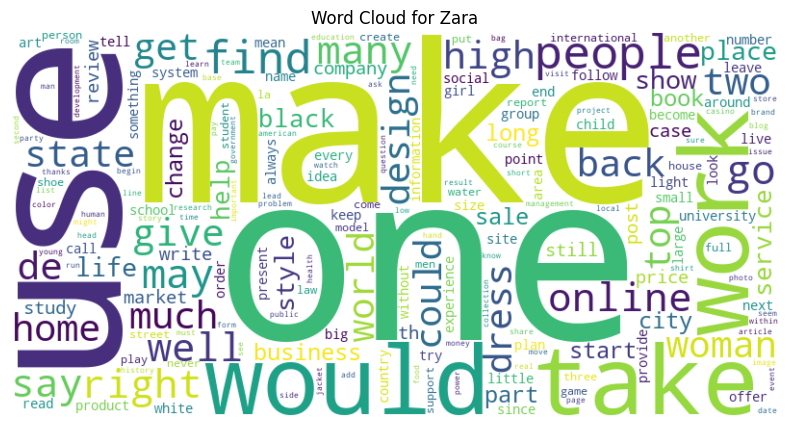

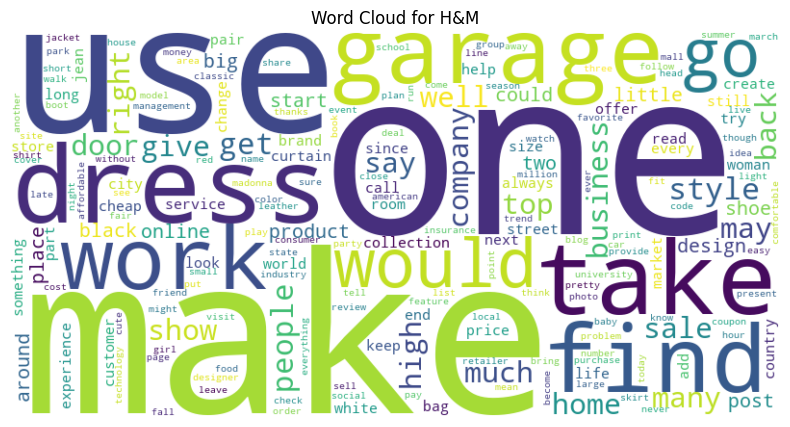

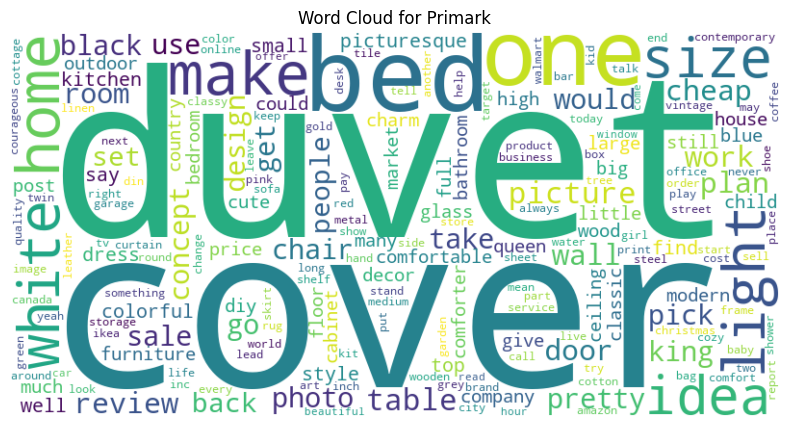

In [230]:
for brand in relevant_df['brand_name'].unique():
    brand_df = relevant_df[relevant_df['brand_name'] == brand]
    all_words = []
    for doc in brand_df['content']:
        all_words.extend(doc.split())
    word_counts = Counter(all_words)
    
    # Plot word cloud for each brand
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.title(f"Word Cloud for {brand}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

There are lots of stop words and no derived insight

## Excluding additonal English stop words after seeing word cloud

In [239]:
# Words to exclude from the results because they are either meaningless or brand names
custom_stopwords = set([
    'zara', 'primark', 'h&m', 'hm', 'brand', 'brands', 'll', '00', 'xx', 'com',
    'got', 've', 'thanks', 'don', 'said', 'year', 'really', 'new', 'like',
    'just', 'make', 'home', 'one', 'use', 'make', 'find', 'work', 'people', 'work', 'say'
])

# Combine custom stopwords with the default English stopwords from scikit-learn
all_stopwords = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))

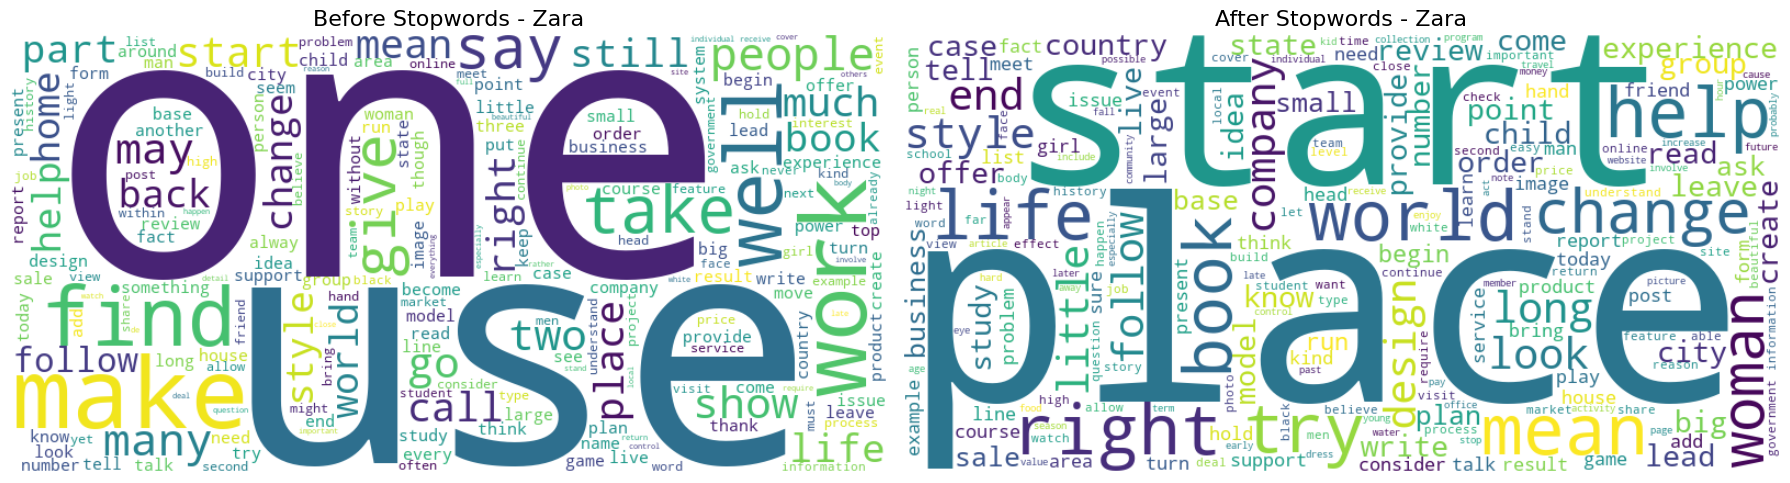

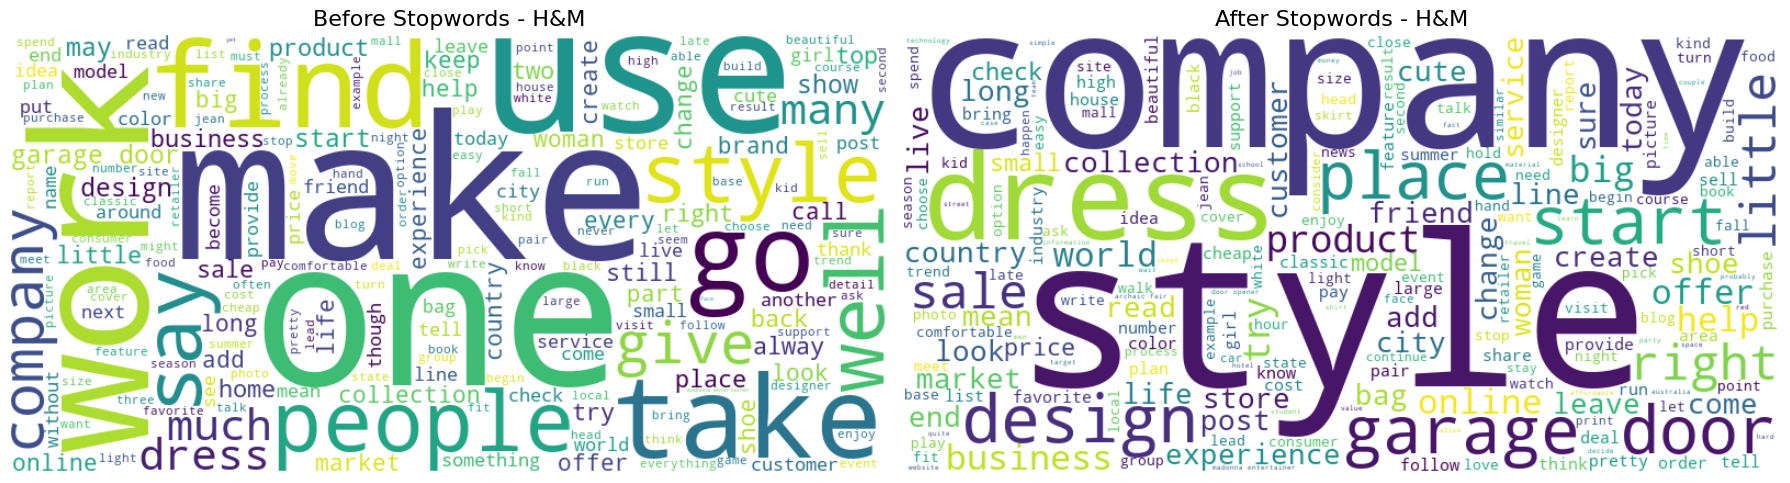

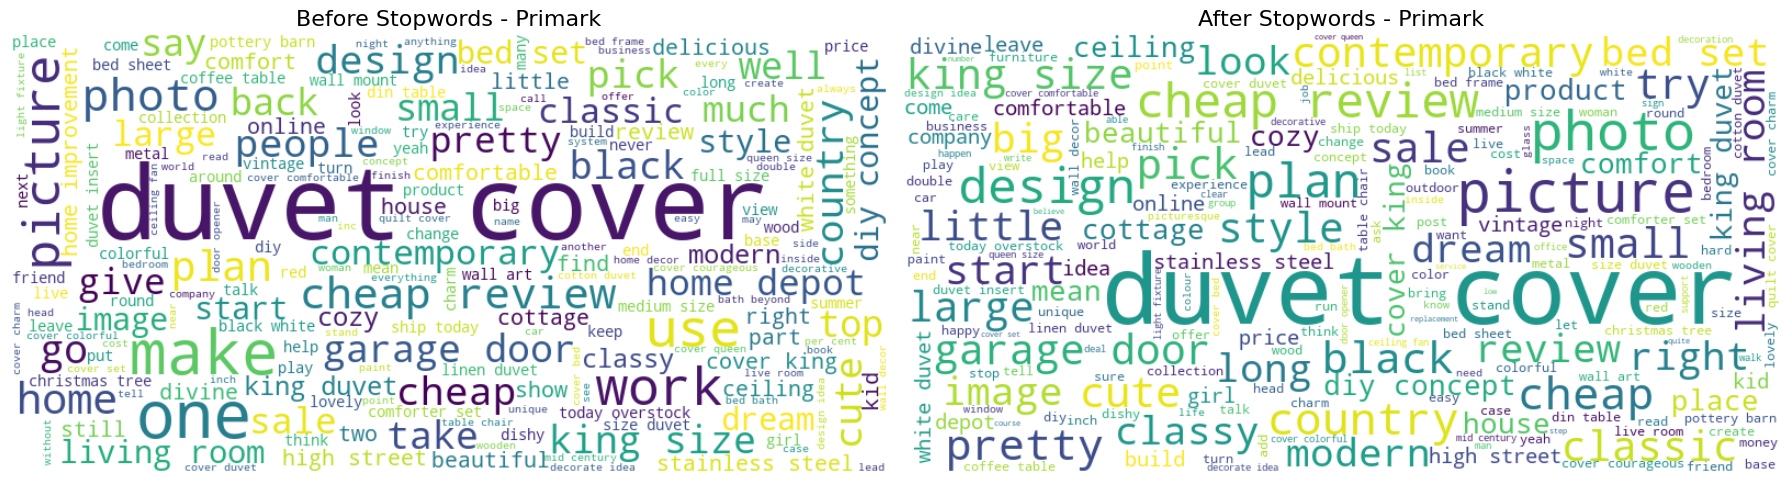

In [240]:
for brand_name in relevant_df['brand_name'].unique():
    df_brand = relevant_df[relevant_df['brand_name'] == brand_name]
    
    # Combine all text into one string for the brand
    all_text = ' '.join(df_brand['content'])
    
    # --- Word Cloud BEFORE stopwords --`-
    wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    
    # --- Word Cloud AFTER stopwords ---
    wordcloud_after = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(all_text)
    
    # Plot both side by side
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    axs[0].imshow(wordcloud_before, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title(f"Before Stopwords - {brand_name}", fontsize=16)
    axs[1].imshow(wordcloud_after, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title(f"After Stopwords - {brand_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

As the VADER have not derive any insight. The Advanced NLP techniques has been considered to apply.

## Advanced NLP techniques

**Note:**  
This process continues in [Google Colab](https://colab.research.google.com/drive/1ZEYRxHmdzR2mN_asA0oKvewwSqZTBC-4?usp=sharing) due to resource limitations on the AI8 Cloud environment. However, the file is also duplicated within this notebook name; **2_refinedweb_analysis_nlp** to facilitate access for the next person in charge of the project.


In [234]:
spark.stop()

--